<a href="https://colab.research.google.com/github/MilerDiazZevallos/Arequipa-Covid-19/blob/master/Sala_Situacional_Arequipa_GERESA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize Environment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.optimize import curve_fit
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [ ]:
from google.colab import auth
auth.authenticate_user()
 
import gspread
from oauth2client.client import GoogleCredentials
 
gc = gspread.authorize(GoogleCredentials.get_application_default())

# R Function
### References:
### https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb

### https://medium.com/@rburhum/el-martillazo-y-el-huayno-278716f49938

In [ ]:
#@title
# general imports
import numpy as np
import datetime as dt
 
from joblib import Parallel, delayed
 
# matplotlib
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
 
# scipy specifics
from scipy import stats as sps
from scipy.interpolate import interp1d
 
# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)
#print(len(r_t_range))
# best sigma for Perú (prior hyperparameters)
#OPTIMAL_SIGMA = 0.35 # through Kevin's Optimization
OPTIMAL_SIGMA = 0.30
#OPTIMAL_SIGMA = 0.05
 
# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7
 
#@title
def smooth_new_cases(new_cases):
    
    """
    Function to apply gaussian smoothing to cases
    Arguments
    ----------
    new_cases: time series of new cases
    Returns 
    ----------
    smoothed_cases: cases after gaussian smoothing
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """
 
    smoothed_cases = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
 
    #print(smoothed_cases.to_csv('smoothed_cases'))
 
    
    zeros = smoothed_cases.index[smoothed_cases.eq(0)]
    #print(len(zeros))
    
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed_cases.index.get_loc(last_zero) + 1
        #print(last_zero)
        #print(idx_start)
 
    
    smoothed_cases = smoothed_cases.iloc[idx_start:]
    original = new_cases.loc[smoothed_cases.index]
    
    #print(smoothed_cases.head())
    #print(original.head())
 
    #print('End smoothed')
    return original, smoothed_cases
    
 
def calculate_posteriors(sr, sigma=0.15):
 
    """
    Function to calculate posteriors of Rt over time
    Arguments
    ----------
    sr: smoothed time series of new cases
    sigma: gaussian noise applied to prior so we can "forget" past observations
           works like exponential weighting
    Returns 
    ----------
    posteriors: posterior distributions
    log_likelihood: log likelihood given data
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """
 
    # (1) Calculate Lambda
    #print(sr[:-1].tail())
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))
    #print('lam shape', lam.shape)
    
    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    #print('likelihoods shape', likelihoods.shape)
 
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 
    #print('process_matrix shape', process_matrix.shape)
 
    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    #print('process_matrix shape', process_matrix.shape)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()
    #print('prior0 shape', prior0.shape)
 
    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    #print('posteriors shape', posteriors.shape)
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0
 
    #print(sr.index[:-1])
    #print(sr.index[1:])
    
    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):
 
        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood
    
 
def highest_density_interval(pmf, p=.9):
 
    """
    Function to calculate highest density interval 
    from posteriors of Rt over time
    Arguments
    ----------
    pmf: posterior distribution of Rt
    p: mass of high density interval
    Returns 
    ----------
    interval: expected value and density interval
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """
 
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    #print(cumsum.shape)
    
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    most_likely = pmf.idxmax()
 
    interval = pd.Series([most_likely, low, high], index=['ML',f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])
 
    return interval
    
 
def plot_rt(result, ax, state_name):
    
    """
    Function to plot Rt
    Arguments
    ----------
    result: expected value and HDI of posterior
    ax: matplotlib axes 
    state_name: state to be considered
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """
 
    ax.set_title(f"{state_name}")
 
    # Colors
    ABOVE = [1,0,0]  # red
    MIDDLE = [1,1,0] # yellow
    BELOW = [0,1,0]  # green
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,50),
        np.linspace(MIDDLE,ABOVE,50)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    #ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index, values, s=40, lw=.5, c=cmap(color_mapped(values)), edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index), result['Low_90'].values, bounds_error=False, fill_value='extrapolate')
    
    highfn = interp1d(date2num(index), result['High_90'].values, bounds_error=False, fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-05-01'), end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended, lowfn(date2num(extended)), highfn(date2num(extended)), color='k', alpha=.1, lw=0, zorder=3)
 
    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    #ax.xaxis.set_major_locator(mdates.MonthLocator())
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.25, zorder=-2)
    ax.margins(0)
    # Scale of Rt values
    ax.set_ylim(0.0, 2.0)
    ax.set_xlim(pd.Timestamp('2020-05-15'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    # Annotations Rt each two weeks
    for i,j in zip(index,values):
        if i in mondays:
            ax.annotate(str(round(j, 2)),xy=(i,j+0.1), arrowprops=dict(facecolor='black', shrink=0.05),fontsize=14) 
 
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    
    """
    Function to plot standings
    Arguments
    ----------
    mr: results by state
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """
 
 
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize, dpi=150)
 
    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=[.5,.5,.5],
                  ecolor=[.2,.2,.2],
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)
 
 
    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,4.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)
 
 
    fig.set_facecolor('w')
    return fig, ax
 
def run_full_model(cases, sigma=OPTIMAL_SIGMA):
    # initializing result dict
    result = {''}
 
    # smoothing series
    new, smoothed = smooth_new_cases(cases)
    #smooth_new_cases(cases)
 
    # calculating posteriors
    posteriors, log_likelihood = calculate_posteriors(smoothed, sigma=sigma)
    #calculate_posteriors(smoothed, sigma=sigma)
 
    # calculating HDI
    result = highest_density_interval(posteriors, p=.9)
    #highest_density_interval(posteriors, p=.9)
 
    return result

# Doubling-time Function
### References:
### https://github.com/COVID-19-AI-Research-Project/AI-Data-Analysis/blob/master/Projects/1/Prediction_Covid_19_WorldWide.ipynb

###### A large doubling time is good.
###### A constant doubling time - means the measures being taken are effective in controlling the spread
###### An increasing doubling time means - the battle is on winning side
###### A decreasing doubling time-- well danger zone ahead. Do something fast

### https://www.npr.org/sections/health-shots/2020/04/10/829167659/are-we-flattening-the-curve-states-keep-watch-on-coronavirus-doubling-times

In [ ]:
def prediction_country2(df1, tipo, plot=True):
    df_final = df1.copy()
    df_country = df_final
    df_country.reset_index(inplace=True)
    
    x=np.array(range(df_country.shape[0]))
    y=df_country[tipo].values
    #print(x)
 
    def func(x,a,b):
        return a*2**(x/b)
 
    def func1(x, a, b):
        return np.exp(b*(x-a))
  
  
    list_coeff = ['Arequipa']  
    for i in range(10, len(x)+1, 1):
        xdata = x[:i]
        ydata = y[:i]

        popt, pcov = curve_fit(func1,xdata=xdata,ydata=ydata,maxfev=2000)
        """
        try:
            popt, pcov = curve_fit(func1,xdata=xdata,ydata=ydata)
        except:
            popt = np.array([0,0])"""
        
        #print(i, xdata, ydata, popt)
        
        popt_aux = popt[1]
        popt[1] = np.log(2.)/popt[1]
        list_coeff.append(popt)
  
    if plot:
        fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
 
        #perc = np.diff(ydata) / ydata[:-1]
        #yfit = popt[0]*2**(xdata/popt[1])
        #perc_fit = np.diff(yfit) / yfit[:-1]
 
        #tdbl1 = np.log(2.)/popt[1]
        #print('popt1 =', popt, ', doubling time = {:.1f} days\n'.format(tdbl1))
 
        ax1.set_ylabel('Total infected in '+ 'Arequipa',fontsize=20)
        #ax1.set_yscale('log')
        ax1.plot(df_country[tipo],'--o',ms=10,label='Real Data')
        #ax1.plot(xdata,yfit,'-',label=f'Exponential fit {round(popt[0],1)}*2^(t/{round(popt[1],1)}), \n doubling time = {round(popt[1],1)} days')
        ax1.plot(xdata,func1(xdata, popt[0], popt_aux),'-',label=f'Exponential fit np.exp({popt[1]}*(t-{popt[0]})), \n doubling time = {popt[1]} days')
        ax1.legend(fontsize=15)
        plt.show()
 
    return list_coeff
 
def get_country_double(df,country):
    df_coeff2 = df[country].str[-1]
    df_coeff1 = df[country].str[0]
    df_coeff2.dropna(inplace=True)
    df_coeff1.dropna(inplace=True)
    #df_coeff2 = np.log(2.)/df_coeff2.astype(str).astype(float)
    df_coeff2 = df_coeff2.astype(str).astype(float)
    df_coeff1 = df_coeff1.astype(str).astype(float)
    df_double = pd.concat([df_coeff1, df_coeff2], axis=1, join='outer')
    df_double.columns = ['Coeff1','Doubling Time in Days']
    return df_double

# Funciones Auxiliares

In [ ]:
import requests 

def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

In [ ]:
url_sinadef="SINADEF_DATOS_ABIERTOS_25032021.xlsx"
download_url("https://cloud.minsa.gob.pe/s/NctBnHXDnocgWAg/download?path=%2F&files="+url_sinadef, url_sinadef)

In [ ]:
SINADEF_File="fallecidos_sinadef.csv"
download_url("https://cloud.minsa.gob.pe/s/nqF2irNbFomCLaa/download",SINADEF_File) 
datos_SINADEF = pd.read_csv(SINADEF_File, encoding = "ISO-8859-1", sep=";")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,3,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#url_sinadef="https://cloud.minsa.gob.pe/s/NctBnHXDnocgWAg/download?path=%2F&files=SINADEF_DATOS_ABIERTOS_25032021.xlsx&downloadStartSecret=b9n0l9odbvq"
datos_sinadef_old = pd.read_excel(url_sinadef, sheet_name='Tabla_SINADEF', skiprows=range(3), skipfooter=0)
#datos_sinadef_old = pd.read_csv('fallecidos_sinadef.csv', encoding = "ISO-8859-1", sep=";")

In [ ]:
datos_sinadef_old.tail()

,Nº,TIPO SEGURO,SEXO,EDAD,TIEMPO EDAD,ESTADO CIVIL,NIVEL DE INSTRUCCIÓN,COD# UBIGEO DOMICILIO,PAIS DOMICILIO,DEPARTAMENTO DOMICILIO,PROVINCIA DOMICILIO,DISTRITO DOMICILIO,FECHA,AÑO,MES,TIPO LUGAR,INSTITUCION,MUERTE VIOLENTA,NECROPSIA,DEBIDO A (CAUSA A),CAUSA A (CIE-X),DEBIDO A (CAUSA B),CAUSA B (CIE-X),DEBIDO A (CAUSA C),CAUSA C (CIE-X),DEBIDO A (CAUSA D),CAUSA D (CIE-X),DEBIDO A (CAUSA E),CAUSA E (CIE-X),DEBIDO A (CAUSA F),CAUSA F (CIE-X)
616540,616541,SIS,FEMENINO,59,AÑOS,SOLTERO,SECUNDARIA INCOMPLETA,92-33-14-06-13-000,PERU,LIMA,HUAROCHIRI,RICARDO PALMA,2021-03-01,2021,3,EESS,MINSA,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,HIPOXEMIA REFRACTARIA,J960,INSUFICIENCIA RENAL AGUDA,N179,OBESIDAD,E662,COVID 19,U071,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
616541,616542,ESSALUD,FEMENINO,64,AÑOS,CASADO,IGNORADO,92-33-24-01-05-000,PERU,CALLAO,CALLAO,LA PERLA,2021-03-01,2021,3,EESS,ESSALUD,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA DE TIPO 1,SIN REGISTRO,NEUIMONIA ATIPICA,SIN REGISTRO,COVID 19 VIRUS IDENTIFICADO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
616542,616543,ESSALUD,MASCULINO,64,AÑOS,CASADO,SUPERIOR UNIV. COMP.,92-33-10-01-07-000,PERU,ICA,ICA,SAN JOSE DE LOS MOLINOS,2021-03-01,2021,3,EESS,ESSALUD,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRAORIA AGUDA,J960,NEUMONIA DEBIDA A OTROS VIRUS,J128,COVID-19 VIRUS IDENTIFICADO,U071,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
616543,616544,SIS,FEMENINO,76,AÑOS,SOLTERO,IGNORADO,92-33-02-03-05-000,PERU,ANCASH,BOLOGNESI,CAJACAY,2021-03-01,2021,3,EESS,MINSA,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA,J960,ACCIDENTE CEREBROVASCULAR,I634,NEUMONIA,J13X,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
616544,616545,SANIDAD PNP,MASCULINO,58,AÑOS,CASADO,IGNORADO,92-33-14-01-08-000,PERU,LIMA,LIMA,CHORRILLOS,2021-03-01,2021,3,EESS,PRIVADO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA VIRAL,J129,COVID 19,U071,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO


In [ ]:
mondays = [pd.to_datetime('2020-05-04'), pd.to_datetime('2020-05-11'), pd.to_datetime('2020-05-18'), pd.to_datetime('2020-05-25'), \
           pd.to_datetime('2020-06-01'), pd.to_datetime('2020-06-08'), pd.to_datetime('2020-06-15'), pd.to_datetime('2020-06-22'), pd.to_datetime('2020-06-29'), \
           pd.to_datetime('2020-07-06'), pd.to_datetime('2020-07-13'), pd.to_datetime('2020-07-20'), pd.to_datetime('2020-07-27'), \
           pd.to_datetime('2020-08-03'), pd.to_datetime('2020-08-10'), pd.to_datetime('2020-08-17'), pd.to_datetime('2020-08-24'),  pd.to_datetime('2020-08-31'), \
           pd.to_datetime('2020-09-07'), pd.to_datetime('2020-09-14'), pd.to_datetime('2020-09-21'), pd.to_datetime('2020-09-28'), \
           pd.to_datetime('2020-10-05'), pd.to_datetime('2020-10-12'), pd.to_datetime('2020-10-19'), pd.to_datetime('2020-10-26'), \
           pd.to_datetime('2020-11-02'), pd.to_datetime('2020-11-09'), pd.to_datetime('2020-11-16'), pd.to_datetime('2020-11-23'), pd.to_datetime('2020-11-30'), \
           pd.to_datetime('2020-12-07'), pd.to_datetime('2020-12-14'), pd.to_datetime('2020-12-21'), pd.to_datetime('2020-12-28'), \
           pd.to_datetime('2021-01-04'), pd.to_datetime('2021-01-11'), pd.to_datetime('2021-01-18'), pd.to_datetime('2021-01-25'), \
           pd.to_datetime('2021-02-01'), pd.to_datetime('2021-02-08'), pd.to_datetime('2021-02-15'), pd.to_datetime('2021-02-22'), \
           pd.to_datetime('2021-03-01'), pd.to_datetime('2021-03-08'), pd.to_datetime('2021-03-15'), pd.to_datetime('2021-03-22'), \
           pd.to_datetime('2021-03-26')]

In [ ]:
# Every two weeks
mondays = [pd.to_datetime('2020-05-04'), pd.to_datetime('2020-05-18'), pd.to_datetime('2020-06-01'), pd.to_datetime('2020-06-15'), \
           pd.to_datetime('2020-06-29'), pd.to_datetime('2020-07-13'), pd.to_datetime('2020-07-27'), pd.to_datetime('2020-08-10'), \
           pd.to_datetime('2020-08-24'), pd.to_datetime('2020-09-07'), pd.to_datetime('2020-09-21'), pd.to_datetime('2020-10-05'), \
           pd.to_datetime('2020-10-19'), pd.to_datetime('2020-11-02'), pd.to_datetime('2020-11-16'), pd.to_datetime('2020-11-30'), \
           pd.to_datetime('2020-12-14'), pd.to_datetime('2020-12-28'), pd.to_datetime('2021-01-11'), pd.to_datetime('2021-01-25'), \
           pd.to_datetime('2021-02-08'), pd.to_datetime('2021-02-22'), pd.to_datetime('2021-03-08'), \
           pd.to_datetime('2021-03-25')]

In [ ]:
dia_semana_sinadef = '2021-03-21'
dia_sinadef = '2021-03-25'

In [ ]:
def plots(ax, type, data, labelx, labely, datax = '', datay = '', label = ''):
    if type == 'line_plt':
        ax.plot(data[datax],'--o',ms=10,label=labely)
        ax.plot(data[datax].rolling(7).mean(),'--o',ms=10,label=labely + ' promedio 7 días')
        ax.tick_params(labelsize=18)
        ax.set_xlabel(labelx,fontsize=28)
        #ax.set_xlim([pd.to_datetime('2020-11-01'),None])
    elif type == 'reg_sns':
        ax = sns.regplot(x=datax, y=datay, data=data, order=3, label=labely, ax=ax)
        ax.tick_params(labelsize=18)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
        #ax.set_xlim([pd.to_datetime('2020-09-01'),None])
    elif type == 'bar_sns':
        ax = sns.barplot(x=data.index, y=datay, data=data, ax=ax)
        ax.tick_params(labelsize=18)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
        #ax.set_xlim([pd.to_datetime('2020-09-01'),None])
    elif type == 'bar_stacked_plt':
        ax.bar(data.index, data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' positivos')
        ax.bar(data.index, data[datay+'_sospechosos'], bottom=data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' sospechosos')
        ax.tick_params(labelsize=18)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
        #ax.set_xlim([pd.to_datetime('2020-09-01'),None])
    elif type == 'bar_stacked_plt_uci':
        ax.bar(data.index, data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' positivos')
        ax.bar(data.index, data[datay+'_sospechosos'], bottom=data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' sospechosos')
        ax.bar(data.index, data['trauma_shock'], bottom=data[datay+'_positivos'] + data[datay+'_sospechosos'], edgecolor='white', width=1, label='trauma shock')
        ax.tick_params(labelsize=18)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
        #ax.set_xlim([pd.to_datetime('2020-09-01'),None])
    elif type == 'line_reg_stacked_sns':
        ax = sns.regplot(x=datax, y=datay+'_positivos', data=data, order=3, label=labely+' positivos', ax=ax)
        ax = sns.regplot(x=datax, y=datay+'_sospechosos', data=data, order=3, label=labely+' sospechosos', ax=ax)
        ax.tick_params(labelsize=18)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
        #ax.set_xlim([pd.to_datetime('2020-09-01'),None])
    ax.legend(fontsize=20)

# Load Data from GERESA

In [ ]:
worksheet = gc.open('DatosArequipa').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

import pandas as pd
datos_arequipa_raw = pd.DataFrame.from_records(rows)

datos_arequipa_raw.columns = datos_arequipa_raw.iloc[0]

datos_arequipa = datos_arequipa_raw.drop([0]).reset_index(drop=True)
display(datos_arequipa.tail())
display(datos_arequipa.shape)

,date,total_muestras,casos_positivos,casos_negativos,espera_resultado,defunciones,recuperados,hospitalizados_positivos,hospitalizados_sospechosos,uci_positivos,uci_sospechosos,trauma_shock,defunciones_minsa,defunciones_essalud,defunciones_clinicas,defunciones_domicilio,defunciones_sanidades
325,2021-03-22,1475043,180755,1290409,3859,3395,171793,442,7,79,0,11,1318,1831,55,129,62
326,2021-03-23,1480555,181108,1295457,3990,3405,172183,484,8,76,0,11,1322,1837,55,129,62
327,2021-03-24,1485621,181440,1299751,4430,3418,172621,479,11,75,0,11,1327,1844,55,129,63
328,2021-03-25,1491246,181842,1306341,3063,3425,172955,470,8,75,0,11,1328,1849,56,129,63
329,2021-03-26,1496309,182255,1311851,2203,3433,173250,462,10,73,0,12,1330,1854,56,130,63


(330, 17)

# Data Cleaning

In [ ]:
datos_arequipa['dia'] = datos_arequipa.index
datos_arequipa['date'] = pd.to_datetime(datos_arequipa['date'])
datos_arequipa['weekday'] = datos_arequipa['date'].dt.weekday
datos_arequipa['week'] = datos_arequipa['date'].dt.week
datos_arequipa['year'] = datos_arequipa['date'].dt.year
datos_arequipa.set_index('date', inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [ ]:
datos_arequipa.index

DatetimeIndex(['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-09', '2020-05-10',
               ...
               '2021-03-17', '2021-03-18', '2021-03-19', '2021-03-20',
               '2021-03-21', '2021-03-22', '2021-03-23', '2021-03-24',
               '2021-03-25', '2021-03-26'],
              dtype='datetime64[ns]', name='date', length=330, freq=None)

In [ ]:
display(datos_arequipa.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 330 entries, 2020-05-01 to 2021-03-26
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   total_muestras              330 non-null    object
 1   casos_positivos             330 non-null    object
 2   casos_negativos             330 non-null    object
 3   espera_resultado            330 non-null    object
 4   defunciones                 330 non-null    object
 5   recuperados                 330 non-null    object
 6   hospitalizados_positivos    330 non-null    object
 7   hospitalizados_sospechosos  330 non-null    object
 8   uci_positivos               330 non-null    object
 9   uci_sospechosos             330 non-null    object
 10  trauma_shock                330 non-null    object
 11  defunciones_minsa           330 non-null    object
 12  defunciones_essalud         330 non-null    object
 13  defunciones_clinicas        330

None

In [ ]:
for column in datos_arequipa.columns:
    datos_arequipa[column] = datos_arequipa[column].astype(int)

In [ ]:
display(datos_arequipa.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 330 entries, 2020-05-01 to 2021-03-26
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   total_muestras              330 non-null    int64
 1   casos_positivos             330 non-null    int64
 2   casos_negativos             330 non-null    int64
 3   espera_resultado            330 non-null    int64
 4   defunciones                 330 non-null    int64
 5   recuperados                 330 non-null    int64
 6   hospitalizados_positivos    330 non-null    int64
 7   hospitalizados_sospechosos  330 non-null    int64
 8   uci_positivos               330 non-null    int64
 9   uci_sospechosos             330 non-null    int64
 10  trauma_shock                330 non-null    int64
 11  defunciones_minsa           330 non-null    int64
 12  defunciones_essalud         330 non-null    int64
 13  defunciones_clinicas        330 non-null    in

None

# Data Pre-processing


In [ ]:
datos_arequipa['muestras_diarias'] = datos_arequipa['total_muestras'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['confirmados_diarios'] = datos_arequipa['casos_positivos'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['fallecidos_diarios'] = datos_arequipa['defunciones'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['recuperados_diarios'] = datos_arequipa['recuperados'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['hospitalizados_positivos_diarios'] = datos_arequipa['hospitalizados_positivos'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['uci_positivos_diarios'] = datos_arequipa['uci_positivos'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['positividad'] = (datos_arequipa['confirmados_diarios'] / datos_arequipa['muestras_diarias'] * 100).fillna(0).astype(int)
datos_arequipa['mesdia'] = datos_arequipa.index.strftime('%m-%d')
datos_arequipa['activos'] = datos_arequipa.casos_positivos - \
                            datos_arequipa.defunciones - \
                            datos_arequipa.recuperados 
datos_arequipa['F_MINSA_dia'] = datos_arequipa['defunciones_minsa'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['F_ESSALUD_dia'] = datos_arequipa['defunciones_essalud'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int) 
datos_arequipa['F_Clinicas_dia'] = datos_arequipa['defunciones_clinicas'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['F_Sanidades_dia'] = datos_arequipa['defunciones_sanidades'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['F_Domicilio_dia'] = datos_arequipa['defunciones_domicilio'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['F_Promedio-7d'] = datos_arequipa['fallecidos_diarios'].rolling(window=7).mean()
datos_arequipa.tail(8)

,total_muestras,casos_positivos,casos_negativos,espera_resultado,defunciones,recuperados,hospitalizados_positivos,hospitalizados_sospechosos,uci_positivos,uci_sospechosos,trauma_shock,defunciones_minsa,defunciones_essalud,defunciones_clinicas,defunciones_domicilio,defunciones_sanidades,dia,weekday,week,year,muestras_diarias,confirmados_diarios,fallecidos_diarios,recuperados_diarios,hospitalizados_positivos_diarios,uci_positivos_diarios,positividad,mesdia,activos,F_MINSA_dia,F_ESSALUD_dia,F_Clinicas_dia,F_Sanidades_dia,F_Domicilio_dia,F_Promedio-7d
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-19,1465047,180035,1281425,3587,3372,170576,482,7,81,0,10,1309,1817,55,129,62,322,4,11,2021,5790,392,7,201,9,5,6,03-19,6087,5,2,0,0,0,9.142857
2021-03-20,1469729,180358,1285574,3797,3378,170985,476,5,80,0,11,1310,1822,55,129,62,323,5,11,2021,4682,323,6,409,-6,-1,6,03-20,5995,1,5,0,0,0,7.857143
2021-03-21,1473532,180627,1288854,4051,3389,171385,465,6,79,0,10,1317,1826,55,129,62,324,6,11,2021,3803,269,11,400,-11,-1,7,03-21,5853,7,4,0,0,0,7.857143
2021-03-22,1475043,180755,1290409,3859,3395,171793,442,7,79,0,11,1318,1831,55,129,62,325,0,12,2021,1511,128,6,408,-23,0,8,03-22,5567,1,5,0,0,0,7.571429
2021-03-23,1480555,181108,1295457,3990,3405,172183,484,8,76,0,11,1322,1837,55,129,62,326,1,12,2021,5512,353,10,390,42,-3,6,03-23,5520,4,6,0,0,0,7.285714
2021-03-24,1485621,181440,1299751,4430,3418,172621,479,11,75,0,11,1327,1844,55,129,63,327,2,12,2021,5066,332,13,438,-5,-1,6,03-24,5401,5,7,0,1,0,8.285714
2021-03-25,1491246,181842,1306341,3063,3425,172955,470,8,75,0,11,1328,1849,56,129,63,328,3,12,2021,5625,402,7,334,-9,0,7,03-25,5462,1,5,1,0,0,8.571429
2021-03-26,1496309,182255,1311851,2203,3433,173250,462,10,73,0,12,1330,1854,56,130,63,329,4,12,2021,5063,413,8,295,-8,-2,8,03-26,5572,2,5,0,0,1,8.714286


# Plots - Test, Confirmados, Fallecidos

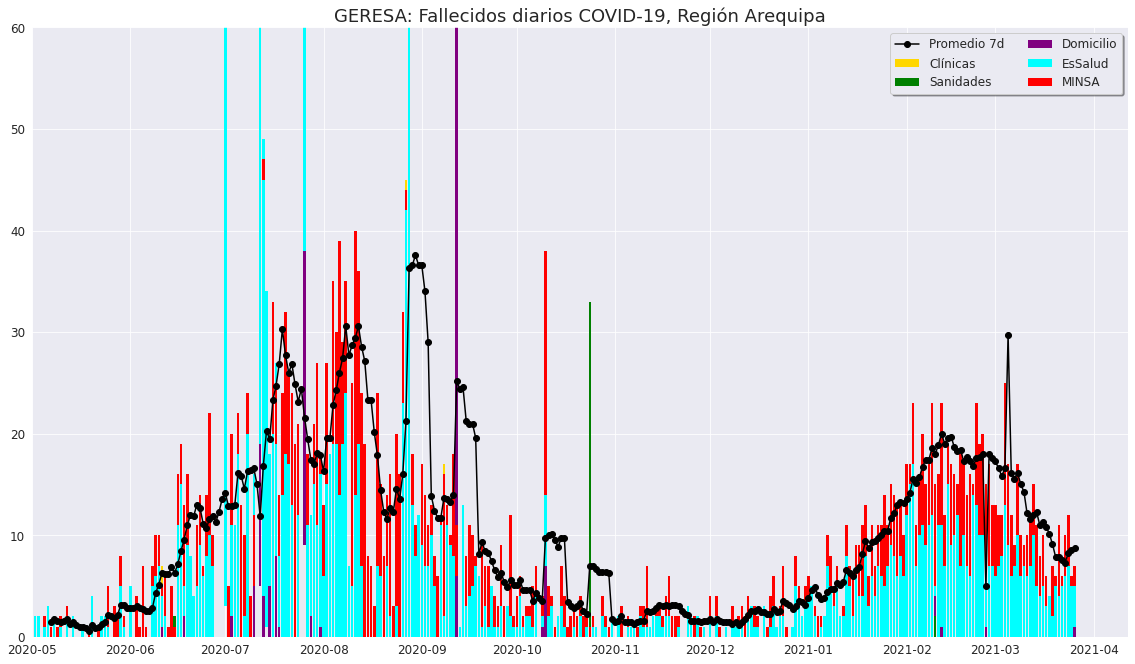

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16,9))

colors = ['red', 'cyan','gold','green', 'purple','black']
labels = ['MINSA', 'EsSalud', 'Clínicas', 'Sanidades', 'Domicilio','Promedio 7d']

ax1.bar(datos_arequipa.index, datos_arequipa['F_Clinicas_dia'], color=colors[2],edgecolor=colors[2], label=labels[2],linewidth=0,bottom=datos_arequipa['F_ESSALUD_dia'])
ax1.bar(datos_arequipa.index, datos_arequipa['F_Sanidades_dia'], color=colors[3], edgecolor=colors[3], label=labels[3],linewidth=0,bottom=datos_arequipa['F_Clinicas_dia'])
ax1.bar(datos_arequipa.index, datos_arequipa['F_Domicilio_dia'], color=colors[4], edgecolor=colors[4], label=labels[4],linewidth=0,bottom=datos_arequipa['F_Sanidades_dia'])
ax1.bar(datos_arequipa.index, datos_arequipa['F_ESSALUD_dia'], color=colors[1], edgecolor=colors[1], label=labels[1],linewidth=0,bottom=datos_arequipa['F_Domicilio_dia'])
ax1.bar(datos_arequipa.index, datos_arequipa['F_MINSA_dia'], color=colors[0], edgecolor=colors[0], label=labels[0],linewidth=0,bottom=datos_arequipa['F_ESSALUD_dia'])
ax1.plot_date(datos_arequipa.index, datos_arequipa['F_Promedio-7d'],color=colors[5], label=labels[5],linestyle='-')

ax1.legend(fancybox=True, shadow=True, ncol=2,fontsize=12)

fig.tight_layout()
ax1.tick_params(labelsize=12)
ax1.set_xlim([pd.to_datetime('2020-05-01'),None])
ax1.set_ylim(0,60)

plt.title('GERESA: Fallecidos diarios COVID-19, Región Arequipa',fontsize=18)
#plt.savefig('image_12.png')
plt.savefig('GERESA_FallecidosDiarios.pdf')
plt.show()
plt.clf()

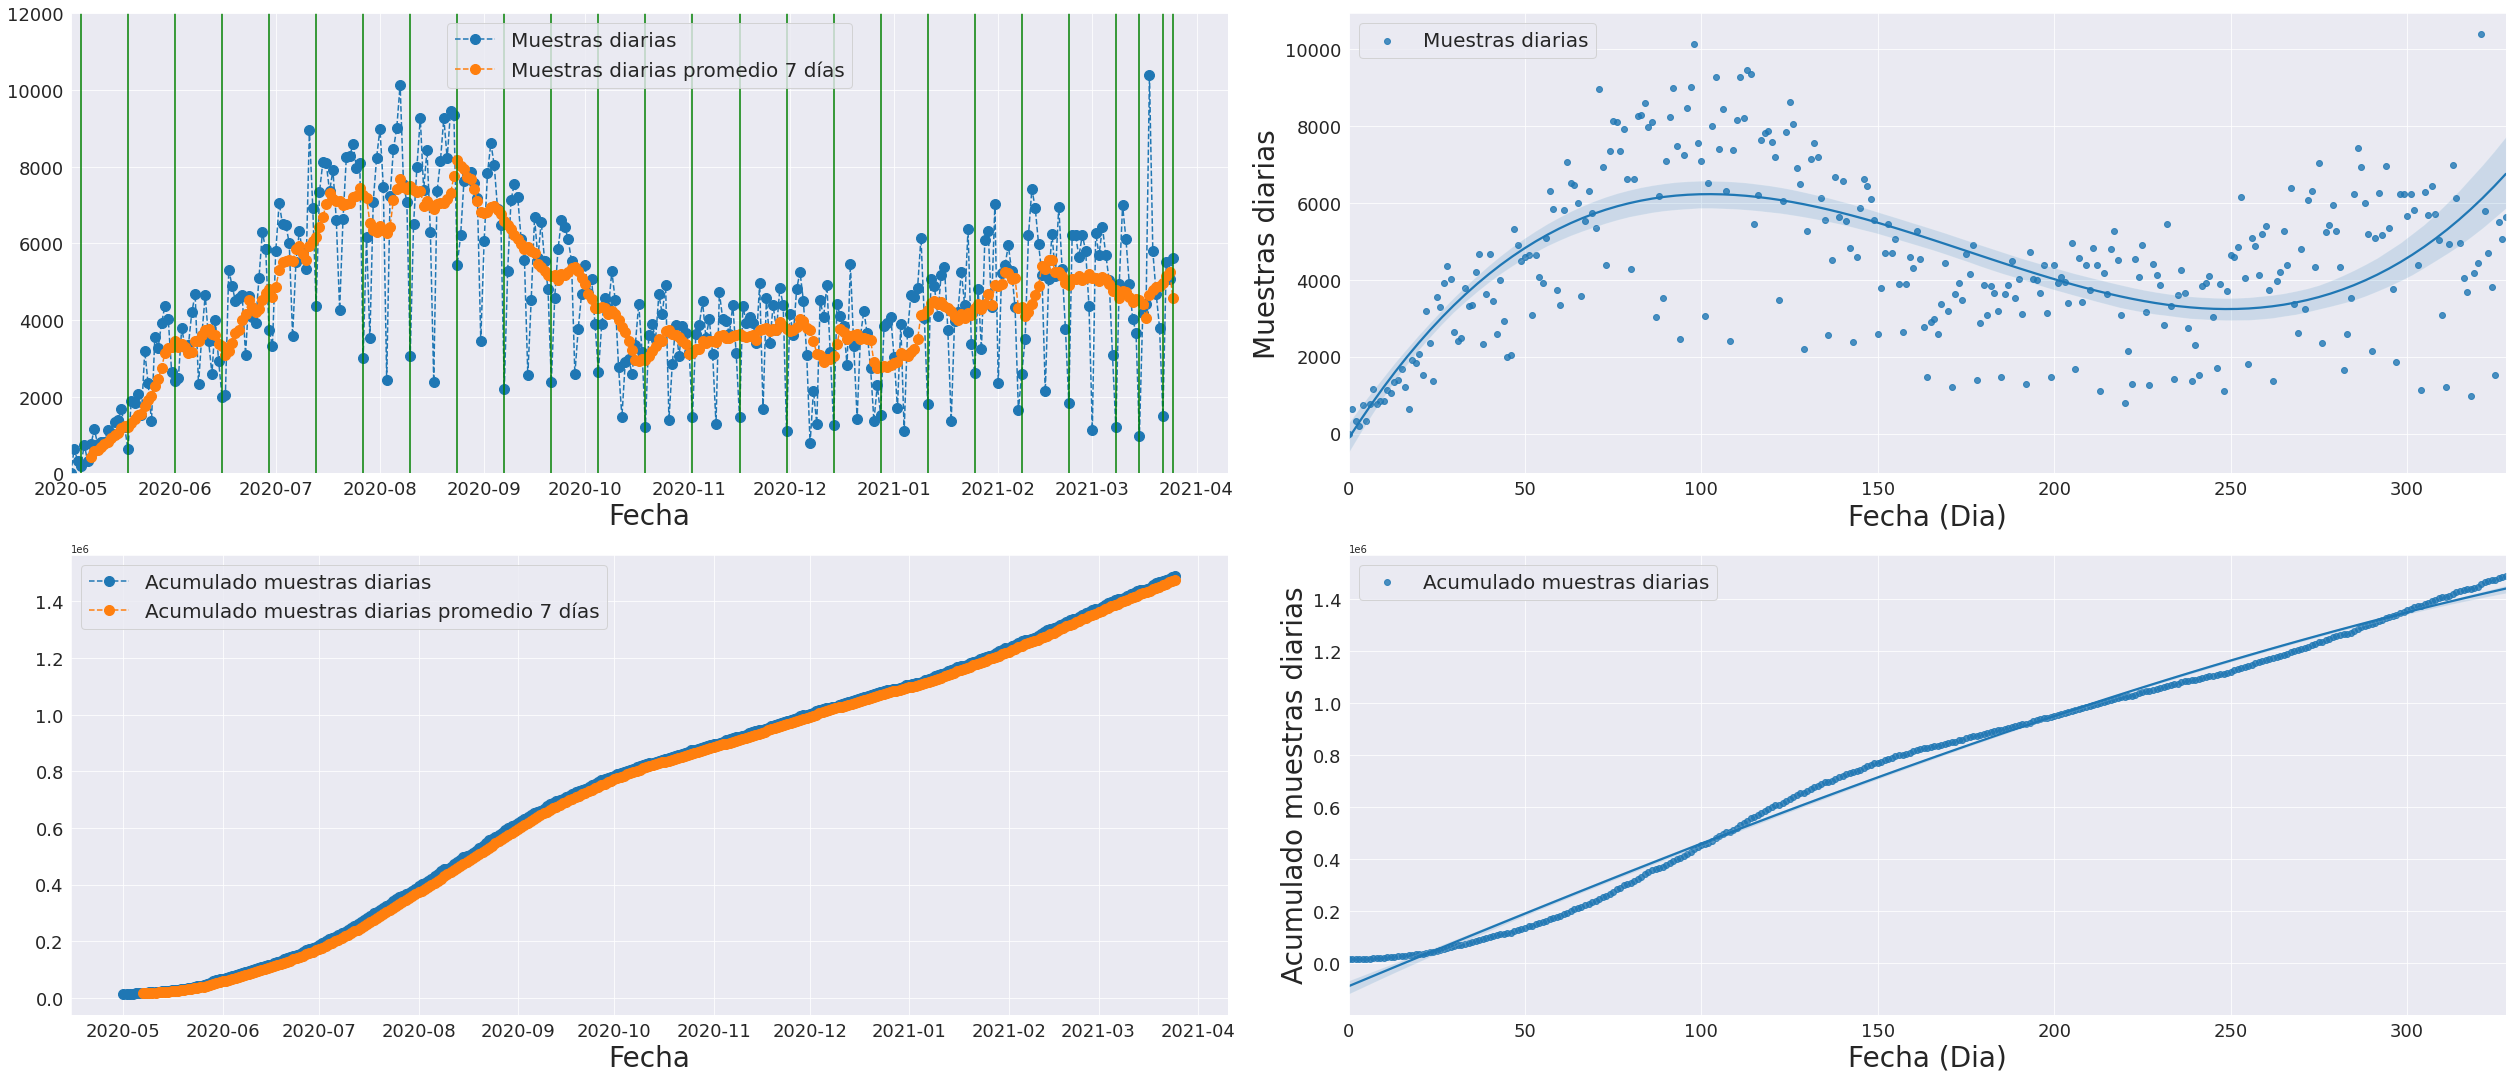

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35, 15))
 
 
plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Muestras diarias', 'muestras_diarias')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Muestras diarias', 'dia', 'muestras_diarias')
plots(ax3, 'line_plt', datos_arequipa, 'Fecha', 'Acumulado muestras diarias', 'total_muestras')
plots(ax4, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Acumulado muestras diarias', 'dia', 'total_muestras')
 
for date in mondays:
    ax1.axvline(date, color='g')
 
fig.tight_layout()
ax1.set_xlim([pd.to_datetime('2020-05-01'),None])
ax1.set_ylim([0,12000])
plt.savefig('image_1.png')
plt.show()

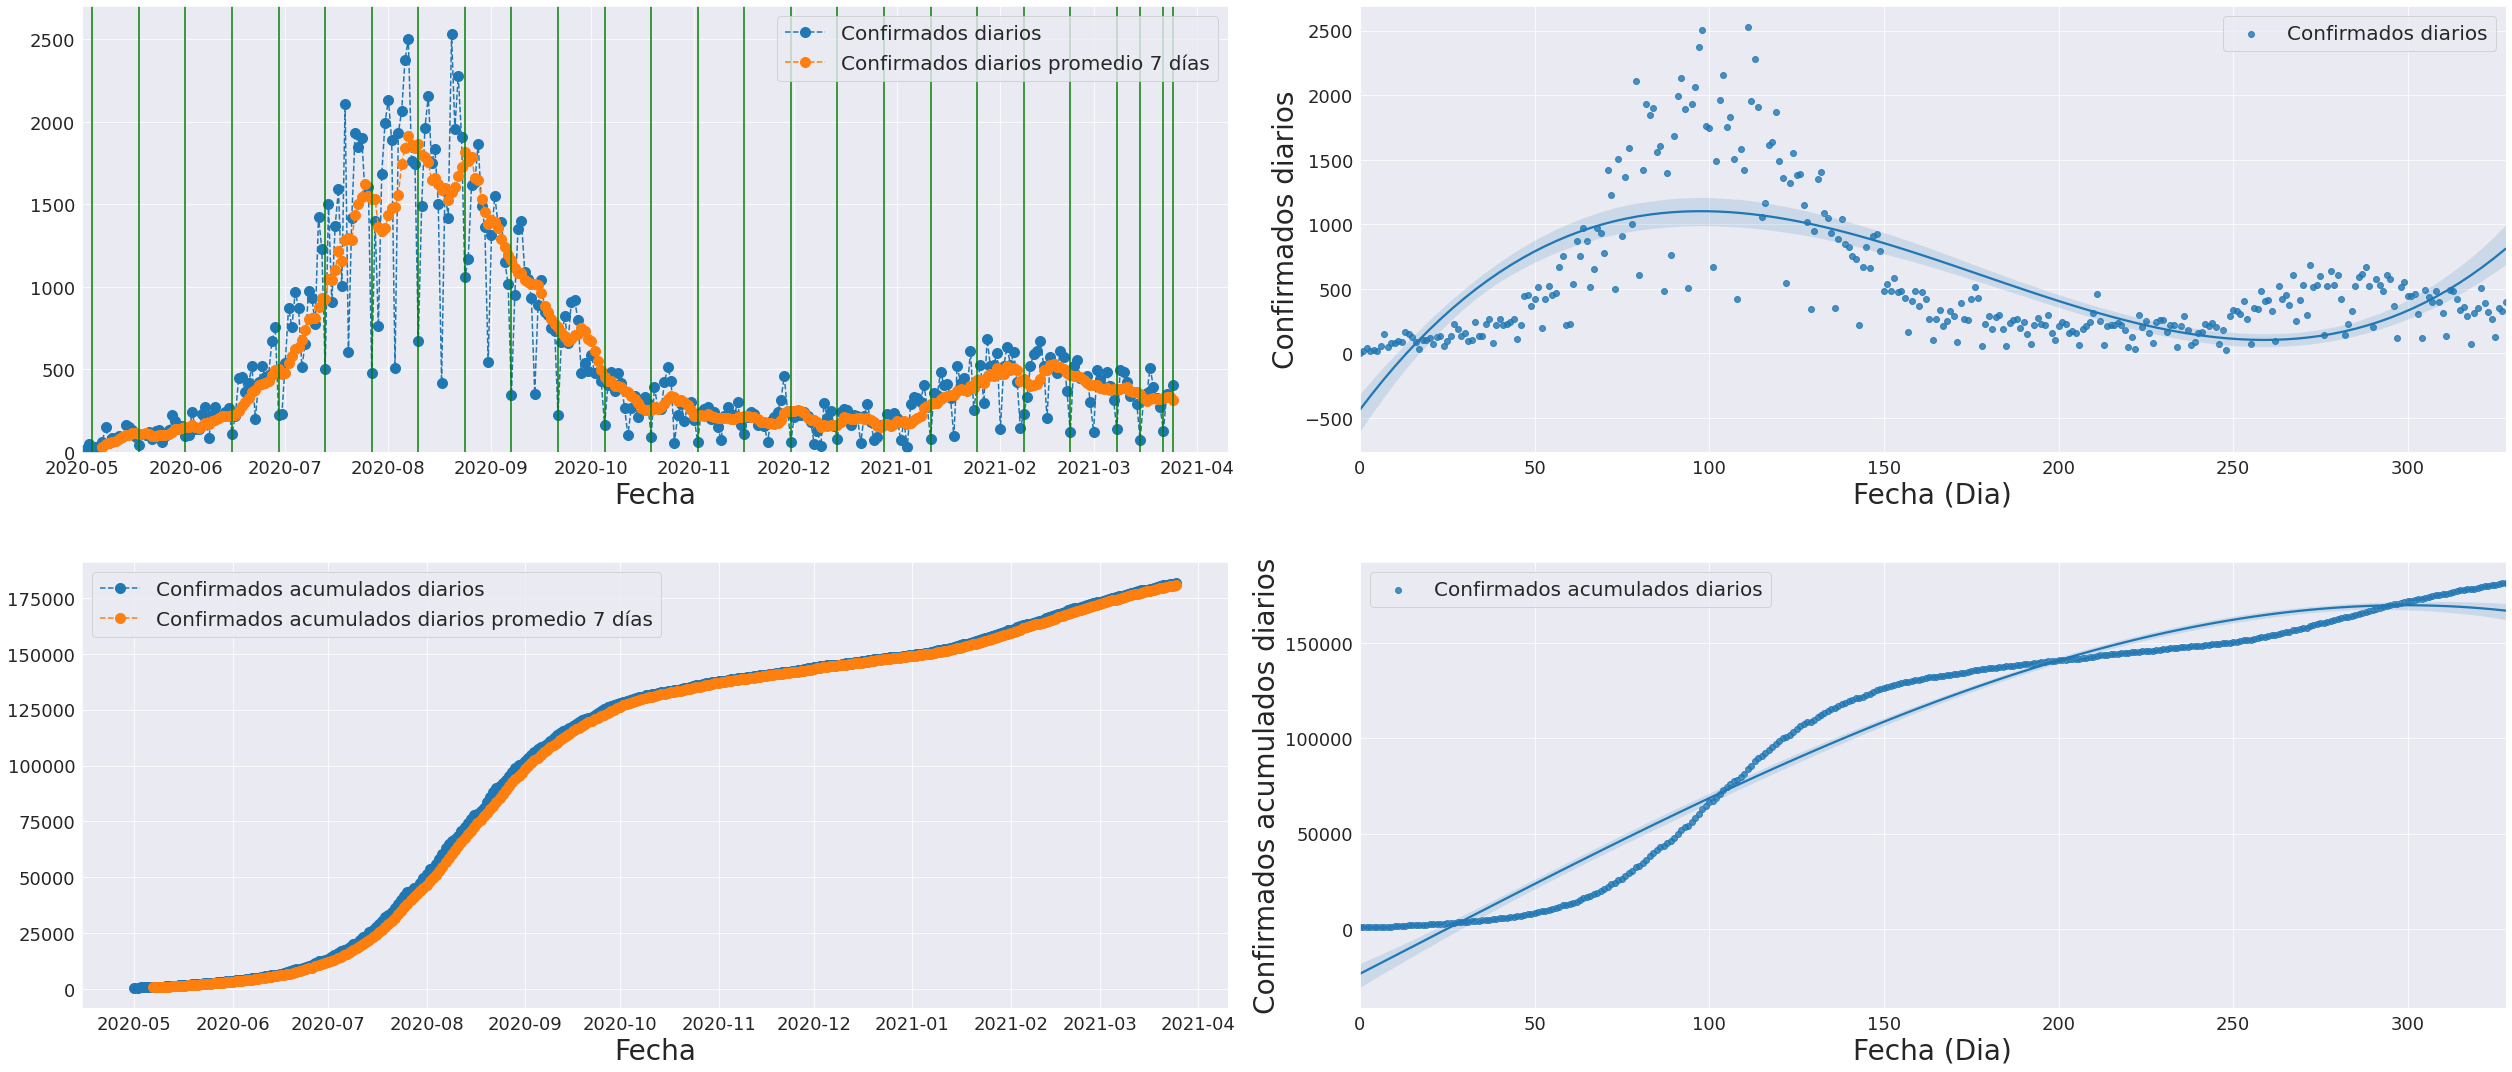

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35, 15))
 
plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Confirmados diarios', 'confirmados_diarios')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Confirmados diarios', 'dia', 'confirmados_diarios')
plots(ax3, 'line_plt', datos_arequipa, 'Fecha', 'Confirmados acumulados diarios', 'casos_positivos')
plots(ax4, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Confirmados acumulados diarios', 'dia', 'casos_positivos')
 
for date in mondays:
    ax1.axvline(date, color='g')
 
fig.tight_layout()
ax1.set_xlim([pd.to_datetime('2020-05-01'),None])
ax1.set_ylim([0,2700])
plt.savefig('image_2.png')
plt.show()

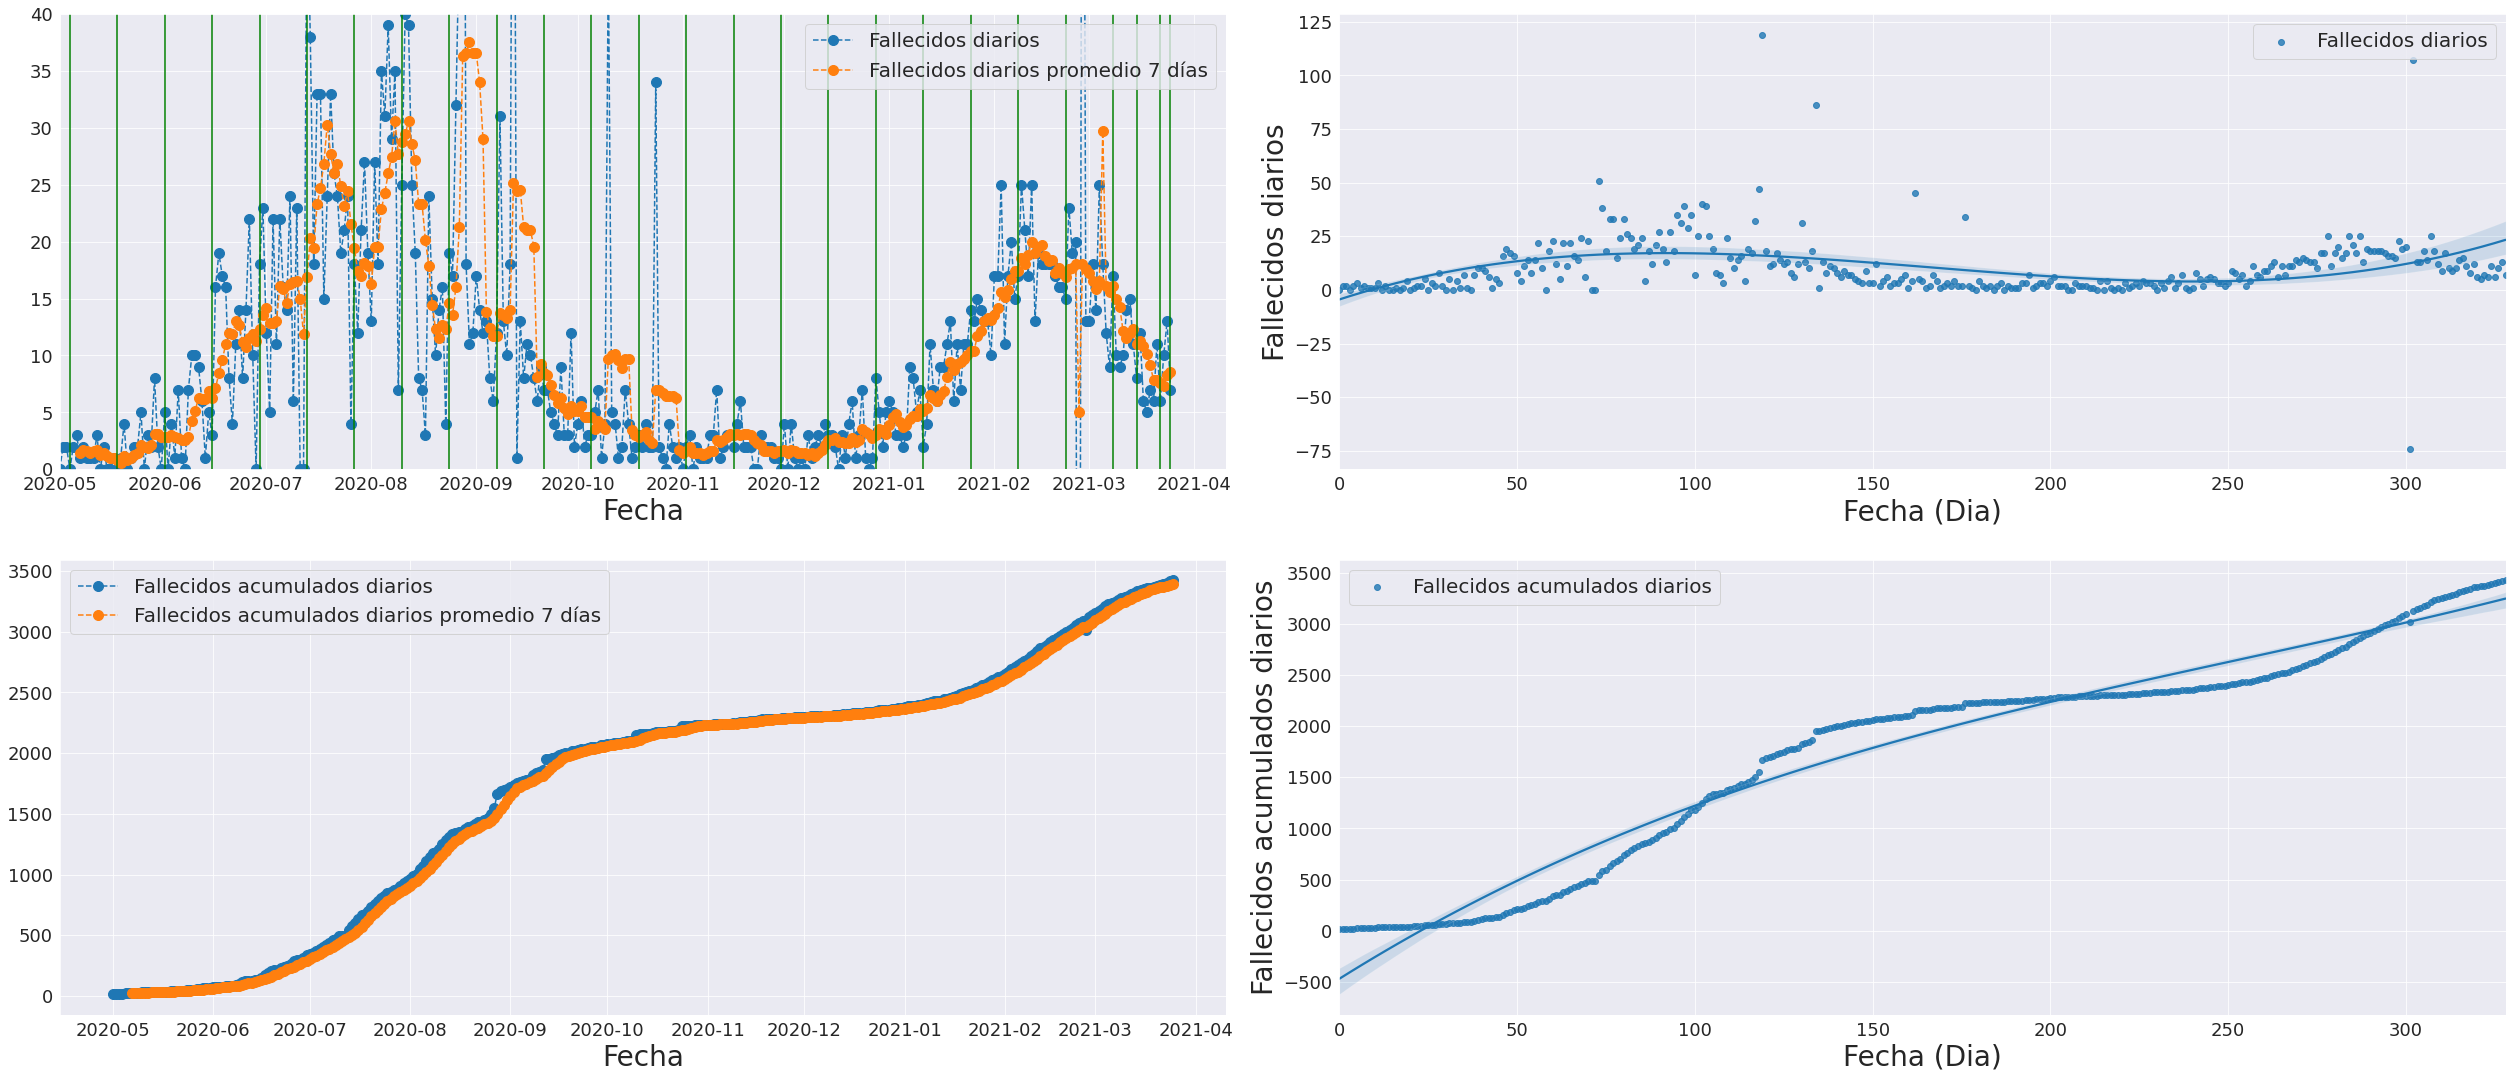

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35, 15))
 
plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Fallecidos diarios', 'fallecidos_diarios')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Fallecidos diarios', 'dia', 'fallecidos_diarios')
plots(ax3, 'line_plt', datos_arequipa, 'Fecha', 'Fallecidos acumulados diarios', 'defunciones')
plots(ax4, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Fallecidos acumulados diarios', 'dia', 'defunciones')
 
for date in mondays:
    ax1.axvline(date, color='g')
 
fig.tight_layout()
ax1.set_xlim([pd.to_datetime('2020-05-01'),None])
ax1.set_ylim([0,40])
plt.savefig('image_3.png')
plt.show()

# Positividad

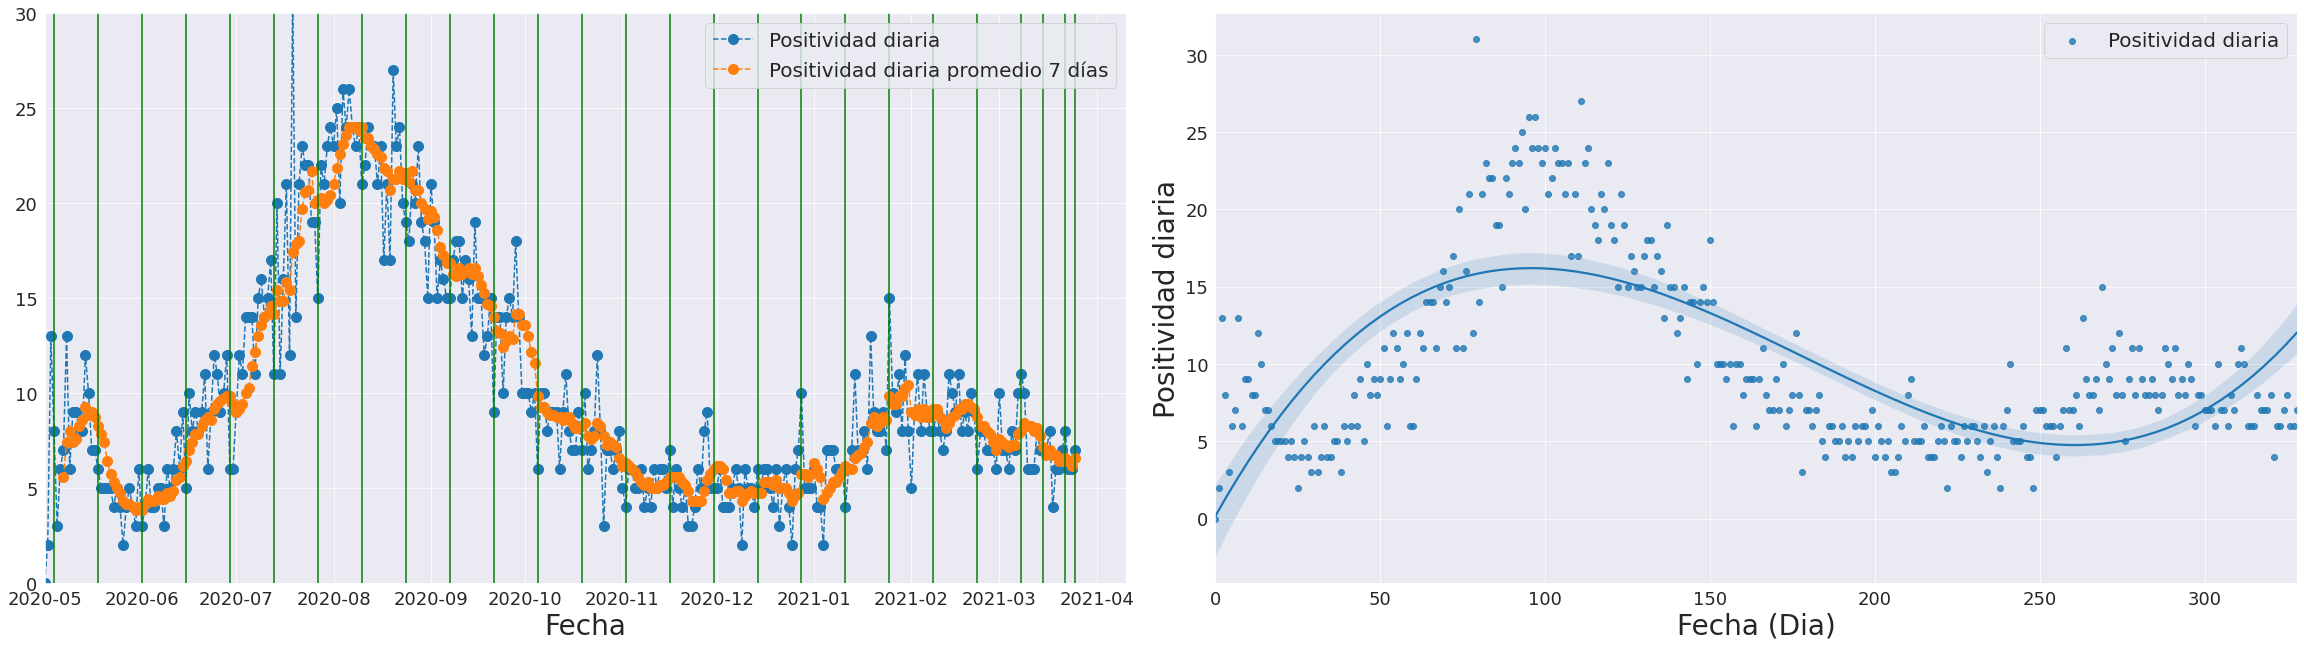

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(32, 9))
 
plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Positividad diaria', 'positividad')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Positividad diaria', 'dia', 'positividad')
 
for date in mondays:
    ax1.axvline(date, color='g')
 
fig.tight_layout()
ax1.set_xlim([pd.to_datetime('2020-05-01'),None])
ax1.set_ylim([0,30])
plt.savefig('image_4.png')
plt.savefig('AQP_Positividad.pdf')
plt.show()

# Factor Salud - Hospitalizados y UCI

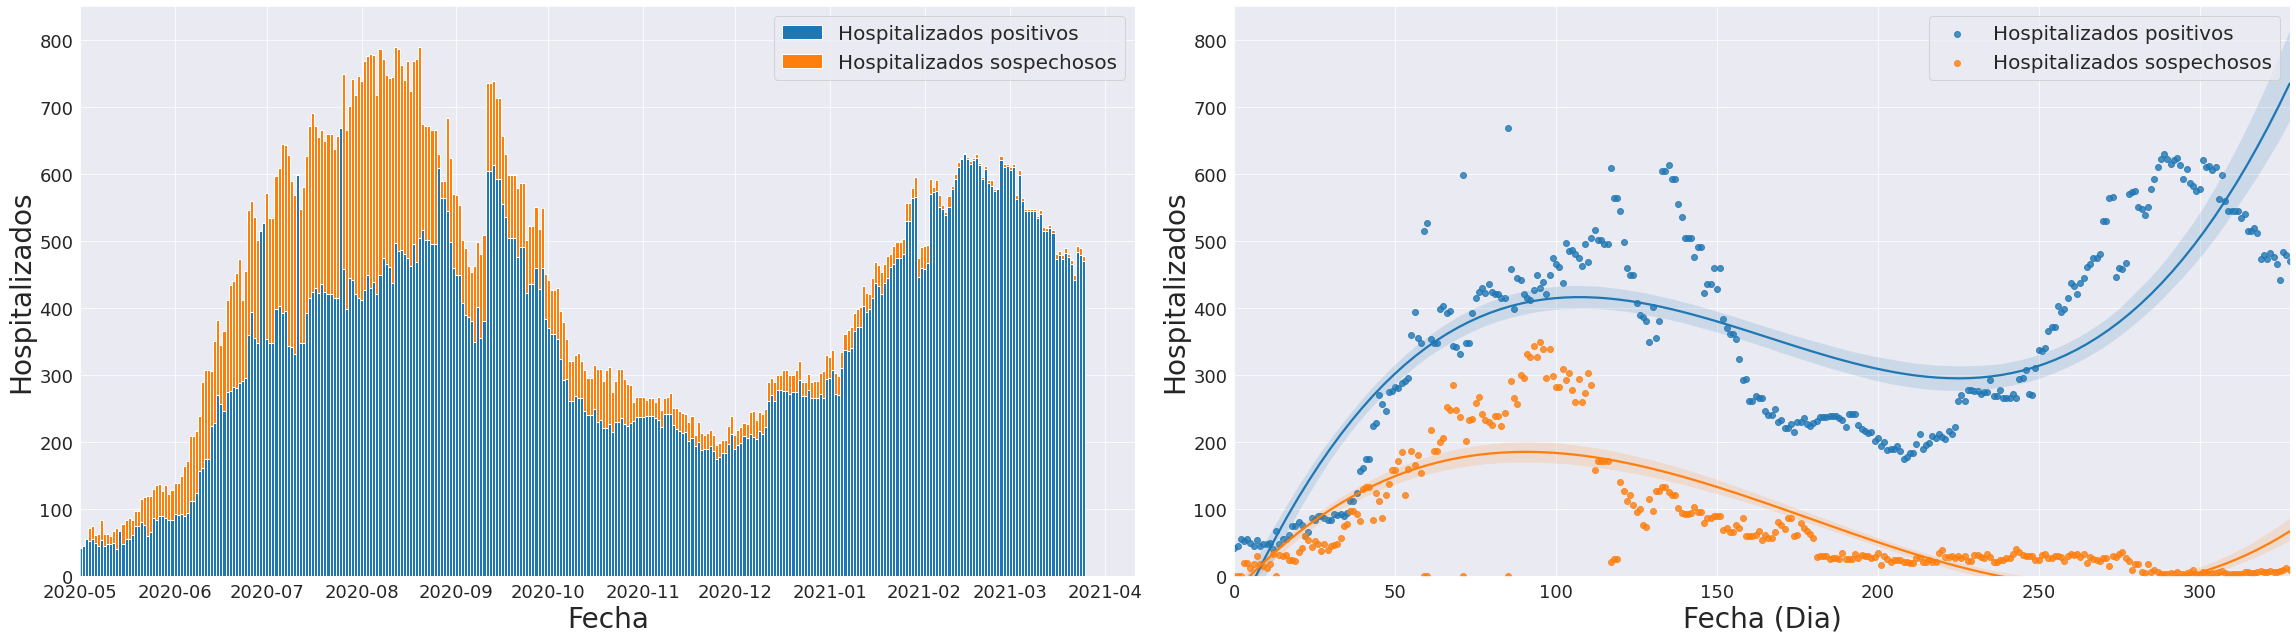

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(32, 9))
 
plots(ax1, 'bar_stacked_plt', datos_arequipa, 'Fecha', 'Hospitalizados', 'index', 'hospitalizados')
plots(ax2, 'line_reg_stacked_sns', datos_arequipa, 'Fecha (Dia)', 'Hospitalizados', 'dia', 'hospitalizados')
 
fig.tight_layout()
ax1.set_xlim([pd.to_datetime('2020-05-01'),None])
ax1.set_ylim([0,850])
ax2.set_ylim([0,850])
plt.savefig('image_5.png')
plt.show()
plt.clf()

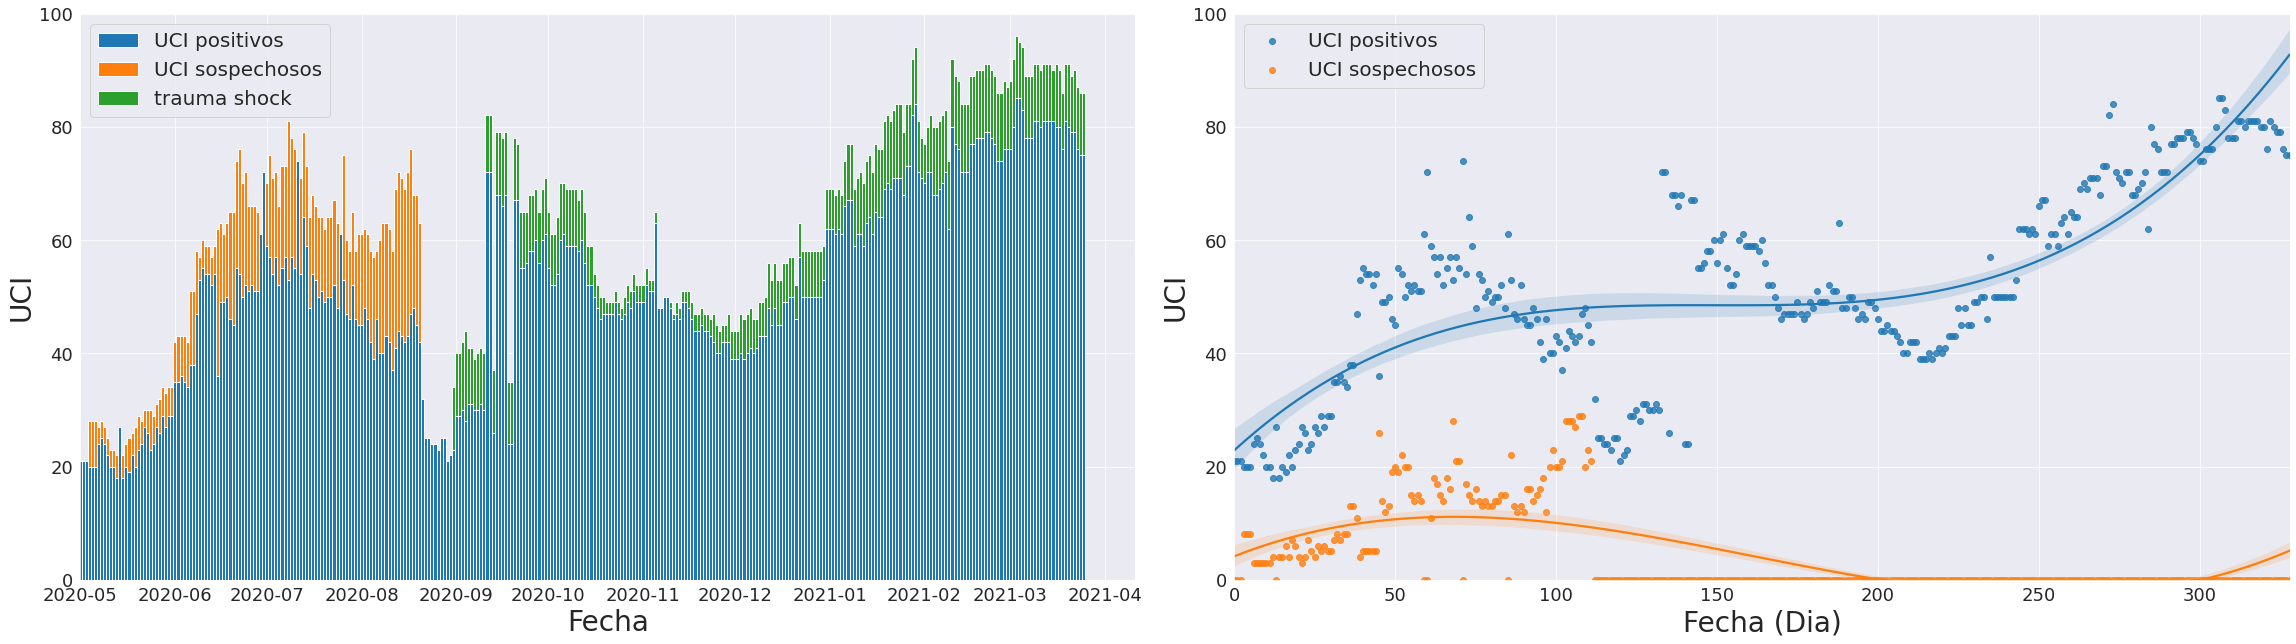

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(32, 9))
 
plots(ax1, 'bar_stacked_plt_uci', datos_arequipa, 'Fecha', 'UCI', 'index', 'uci')
plots(ax2, 'line_reg_stacked_sns', datos_arequipa, 'Fecha (Dia)', 'UCI', 'dia', 'uci')
 
fig.tight_layout()
ax1.set_xlim([pd.to_datetime('2020-05-01'),None])
ax1.set_ylim([0,100])
ax2.set_ylim([0,100])
plt.savefig('image_6.png')
plt.show()
plt.clf()

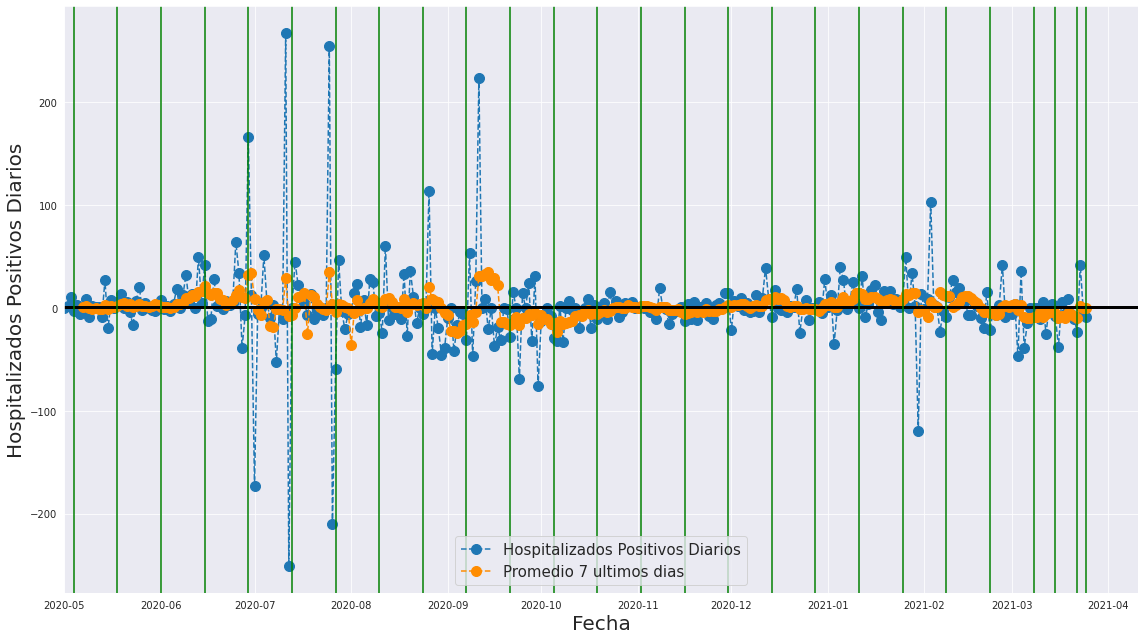

In [ ]:
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(16,9))
ax1.set_ylabel('Hospitalizados Positivos Diarios',fontsize=20)
ax1.set_xlabel('Fecha',fontsize=20)
ax1.plot(datos_arequipa['hospitalizados_positivos_diarios'],'--o',ms=10,label='Hospitalizados Positivos Diarios')
ax1.plot(datos_arequipa['hospitalizados_positivos_diarios'].rolling(7).mean(),'--o',ms=10,label='Promedio 7 ultimos dias', color='darkorange')
ax1.legend(fontsize=15)
 
plt.axhline(1, color='k',lw=3)
for date in mondays:
    ax1.axvline(date, color='g')
 
fig.tight_layout()
ax1.set_xlim([pd.to_datetime('2020-05-01'),None])
plt.savefig('image_7.png')
plt.show()

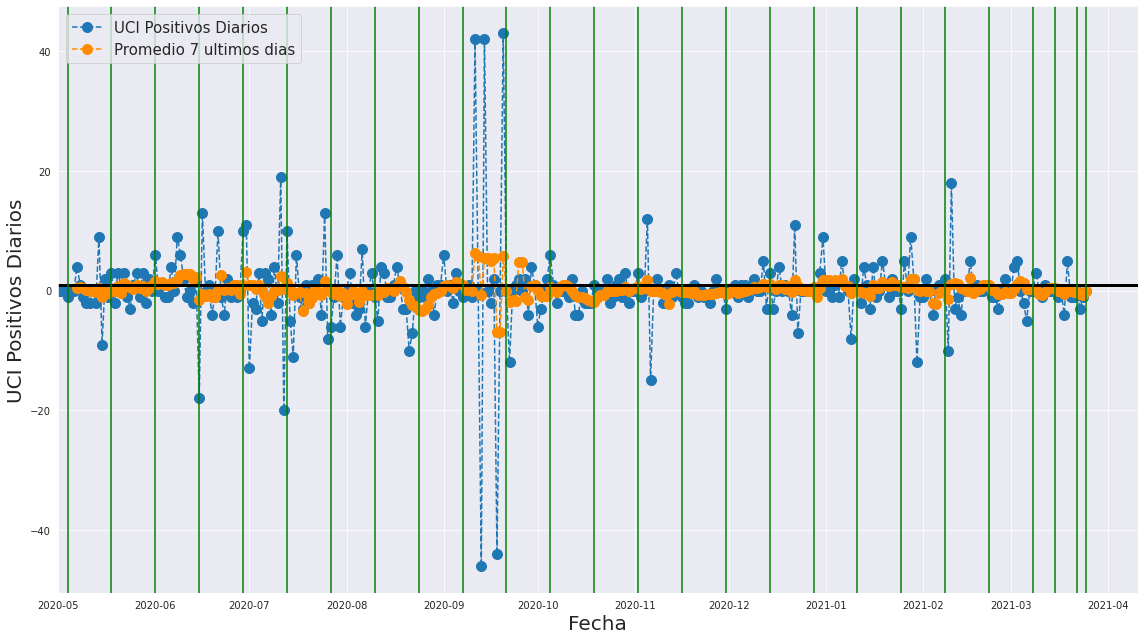

In [ ]:
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(16,9))
 
ax1.set_ylabel('UCI Positivos Diarios',fontsize=20)
ax1.set_xlabel('Fecha',fontsize=20)
ax1.plot(datos_arequipa['uci_positivos_diarios'],'--o',ms=10,label='UCI Positivos Diarios')
ax1.plot(datos_arequipa['uci_positivos_diarios'].rolling(7).mean(),'--o',ms=10,label='Promedio 7 ultimos dias', color='darkorange')
ax1.legend(fontsize=15)
 
plt.axhline(1, color='k',lw=3)
for date in mondays:
    ax1.axvline(date, color='g')
 
fig.tight_layout()
ax1.set_xlim([pd.to_datetime('2020-05-01'),None])
plt.savefig('image_8.png')
plt.show()

# R Factor - Confirmados

In [ ]:
r_confirmados_arequipa = datos_arequipa.loc[:,['confirmados_diarios']]
r_confirmados_arequipa['state'] = 'AREQUIPA'
r_confirmados_arequipa = r_confirmados_arequipa.set_index([r_confirmados_arequipa.index, 'state'])
r_confirmados_arequipa = r_confirmados_arequipa['confirmados_diarios']
display(r_confirmados_arequipa.tail(7))
r_confirmados = run_full_model(r_confirmados_arequipa, sigma=0.01)
#r_confirmados = run_full_model(r_confirmados_arequipa, sigma=0.30)
display(r_confirmados.tail(7))
r_confirmados.to_csv('Rt_Arequipa.csv')

date        state   
2021-03-20  AREQUIPA    323
2021-03-21  AREQUIPA    269
2021-03-22  AREQUIPA    128
2021-03-23  AREQUIPA    353
2021-03-24  AREQUIPA    332
2021-03-25  AREQUIPA    402
2021-03-26  AREQUIPA    413
Name: confirmados_diarios, dtype: int64

,,ML,Low_90,High_90
date,state,,,
2021-03-20,AREQUIPA,0.97,0.88,1.08
2021-03-21,AREQUIPA,0.96,0.86,1.06
2021-03-22,AREQUIPA,0.95,0.85,1.05
2021-03-23,AREQUIPA,0.96,0.86,1.06
2021-03-24,AREQUIPA,0.98,0.88,1.08
2021-03-25,AREQUIPA,0.99,0.89,1.09
2021-03-26,AREQUIPA,1.01,0.91,1.11


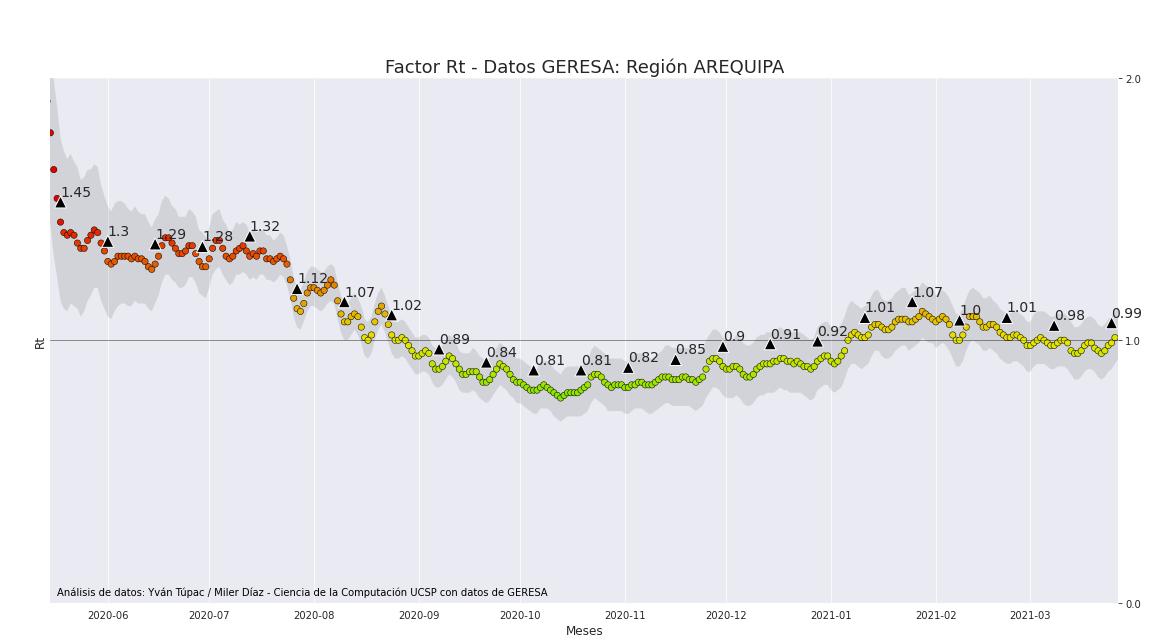

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_rt(r_confirmados, ax,'Factor Rt - Región AREQUIPA')
plt.title('Factor Rt - Datos GERESA: Región AREQUIPA', fontsize=18)
plt.xlabel('Meses',fontsize=12)
plt.ylabel('Rt',fontsize=12)
fig.tight_layout()
fig.set_facecolor('w')

style = dict(size=10, color='k')
ax.text(pd.to_datetime('2020-05-17'), 0.03, "Análisis de datos: Yván Túpac / Miler Díaz - Ciencia de la Computación UCSP con datos de GERESA", **style)
plt.savefig('Rt_Arequipa.pdf')
plt.savefig('Rt_Arequipa.png',dpi=300,transparent=True)
plt.show()
plt.clf()

# R Factor - Fallecidos

In [ ]:
r_fallecidos_arequipa = datos_arequipa.loc[:,['fallecidos_diarios']]
r_fallecidos_arequipa['state'] = 'AREQUIPA'
r_fallecidos_arequipa = r_fallecidos_arequipa.set_index([r_fallecidos_arequipa.index, 'state'])
r_fallecidos_arequipa = r_fallecidos_arequipa['fallecidos_diarios']
 
r_fallecidos = run_full_model(r_fallecidos_arequipa, sigma=0.01)

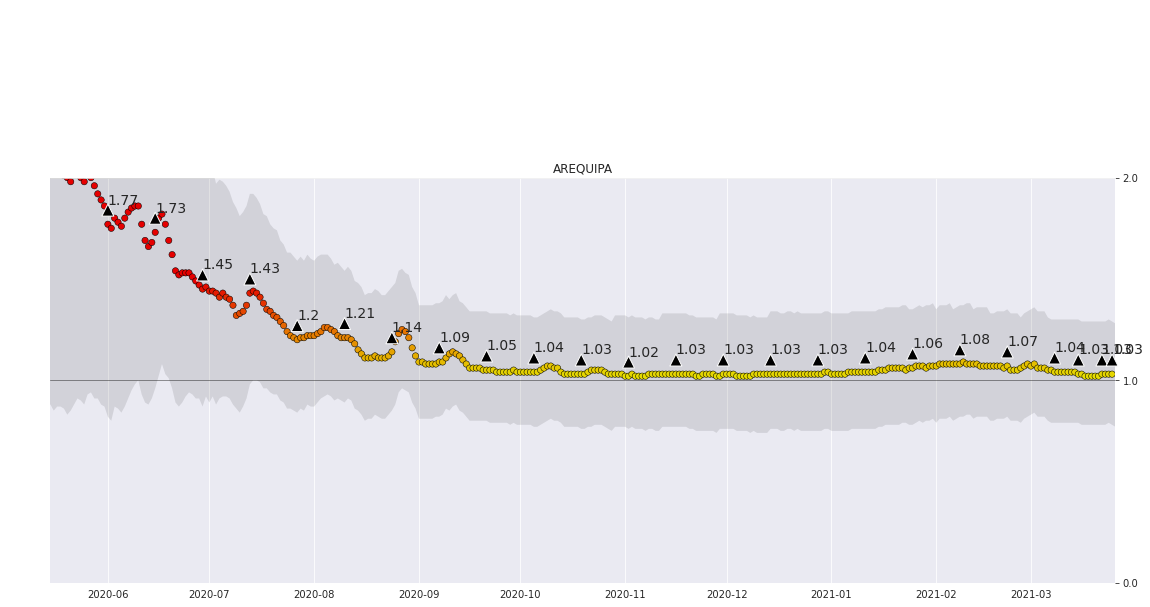

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_rt(r_fallecidos, ax, 'AREQUIPA')
fig.tight_layout()
fig.set_facecolor('w')
plt.show()
plt.clf()

# Plot doubling-time: Casos Positivos

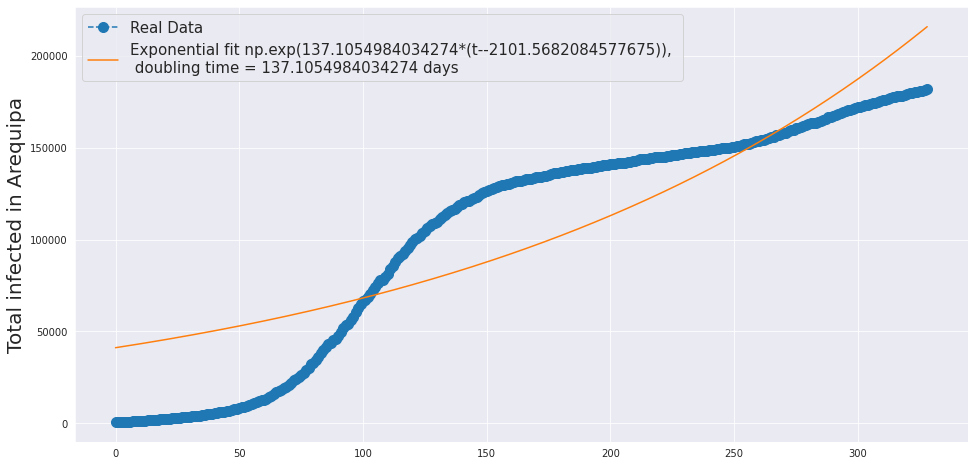

In [ ]:
List = []
coeff = prediction_country2(datos_arequipa,'casos_positivos',plot=True)
List.append(coeff)

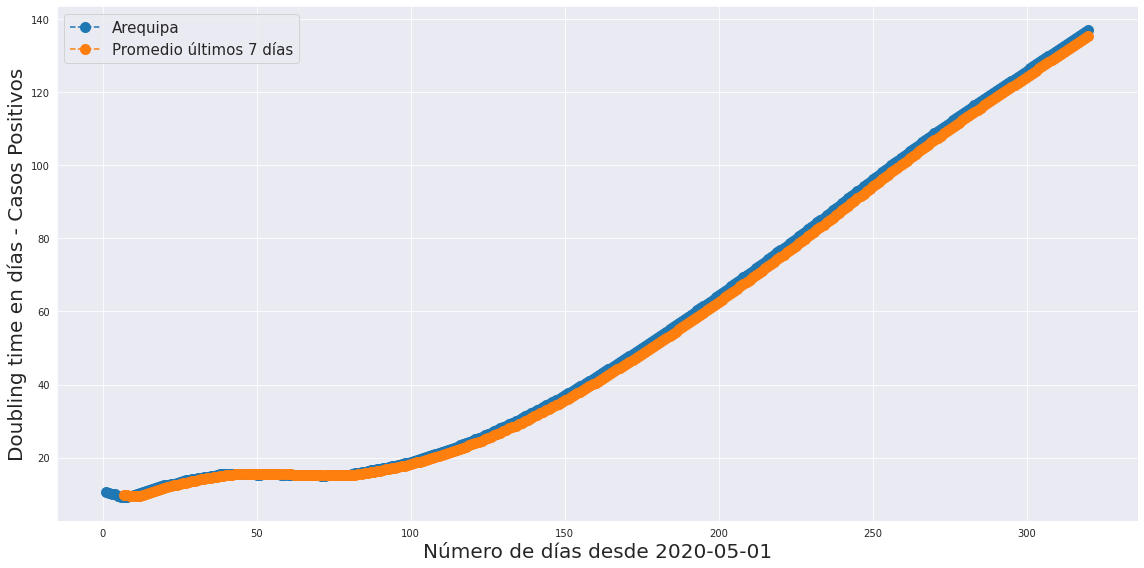

In [ ]:
df_combines = pd.DataFrame(List).T
df_combines.columns = df_combines.iloc[0]
df_combines.drop(df_combines.index[0], inplace=True)

dff_double = get_country_double(df_combines, 'Arequipa')

fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Doubling time en días - Casos Positivos',fontsize=20)
ax1.set_xlabel('Número de días desde 2020-05-01',fontsize=20)
ax1.plot(dff_double['Doubling Time in Days'],'--o',ms=10,label='Arequipa')
ax1.plot(dff_double['Doubling Time in Days'].rolling(7).mean(),'--o',ms=10,label='Promedio últimos 7 días' )
ax1.legend(fontsize=15)
fig.tight_layout()
plt.savefig('image_10.png')
plt.show()

# Plot doubling-time: Fallecidos

In [ ]:
List = []
coeff = prediction_country2(datos_arequipa,'defunciones',plot=False)
List.append(coeff)

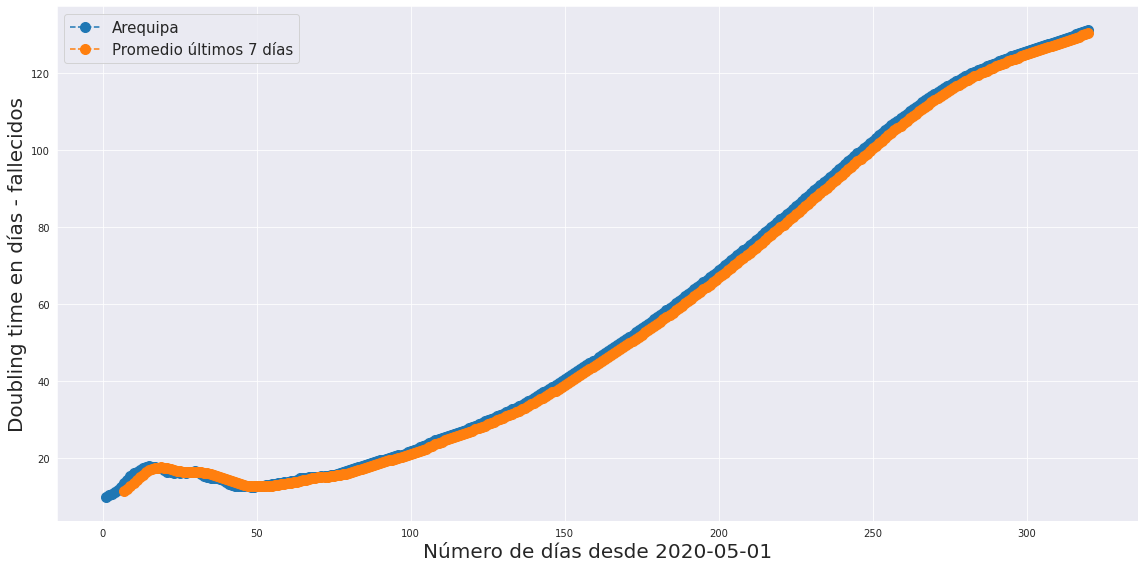

In [ ]:
df_combines = pd.DataFrame(List).T
df_combines.columns = df_combines.iloc[0]
df_combines.drop(df_combines.index[0], inplace=True)

dff_double = get_country_double(df_combines, 'Arequipa')
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Doubling time en días - fallecidos',fontsize=20)
ax1.set_xlabel('Número de días desde 2020-05-01',fontsize=20)
ax1.plot(dff_double['Doubling Time in Days'],'--o',ms=10,label='Arequipa')
ax1.plot(dff_double['Doubling Time in Days'].rolling(7).mean(),'--o',ms=10,label='Promedio últimos 7 días' )
ax1.legend(fontsize=15)
fig.tight_layout()
plt.savefig('image_11.png')
plt.show()

# Plots - Defunciones, Activos, Recuperados

In [ ]:
data_map_arequipa = datos_arequipa.loc[:,['casos_positivos', 'defunciones','recuperados','activos','dia']]
data_map_arequipa['hito1'] = data_map_arequipa['defunciones']
data_map_arequipa['hito2'] = data_map_arequipa['defunciones'] + data_map_arequipa['activos']
data_map_arequipa['hito3'] = data_map_arequipa['defunciones'] + data_map_arequipa['activos'] + data_map_arequipa['recuperados']
data_map_arequipa.tail()

,casos_positivos,defunciones,recuperados,activos,dia,hito1,hito2,hito3
date,,,,,,,,
2021-03-21,180627,3389,171385,5853,324,3389,9242,180627
2021-03-22,180755,3395,171793,5567,325,3395,8962,180755
2021-03-23,181108,3405,172183,5520,326,3405,8925,181108
2021-03-24,181440,3418,172621,5401,327,3418,8819,181440
2021-03-25,181842,3425,172955,5462,328,3425,8887,181842


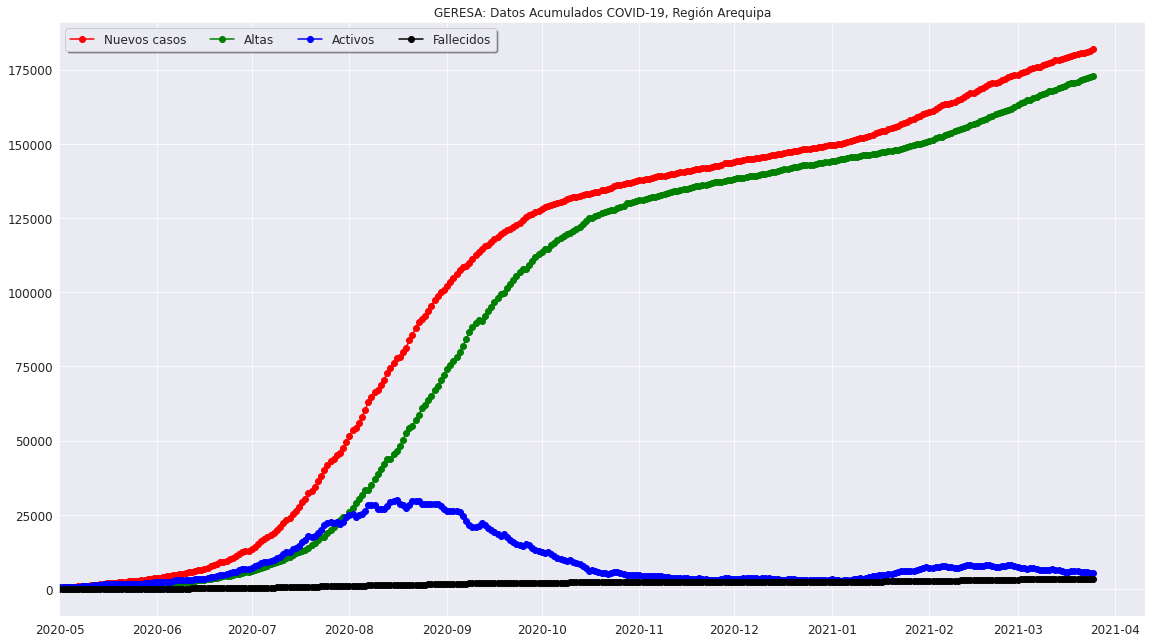

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16,9))

colors = ['red', 'green', 'blue', 'black']
labels = ['Nuevos casos', 'Altas', 'Activos', 'Fallecidos']

ax1.plot_date(data_map_arequipa.index, data_map_arequipa['casos_positivos'], color=colors[0], label=labels[0], linestyle="-")
ax1.plot_date(data_map_arequipa.index, data_map_arequipa['recuperados'], color=colors[1], label=labels[1], linestyle="-")
ax1.plot_date(data_map_arequipa.index, data_map_arequipa['activos'], color=colors[2], label=labels[2], linestyle="-")
ax1.plot_date(data_map_arequipa.index, data_map_arequipa['defunciones'], color=colors[3], label=labels[3], linestyle="-")

ax1.set(title='GERESA: Datos Acumulados COVID-19, Región Arequipa')

ax1.legend(fancybox=True, shadow=True, ncol=4,fontsize=12)

fig.tight_layout()
ax1.tick_params(labelsize=12)
ax1.set_xlim([pd.to_datetime('2020-05-01'),None])
plt.savefig('image_12.png')
plt.savefig('GERESA_Acumulados.pdf')
plt.show()
plt.clf()

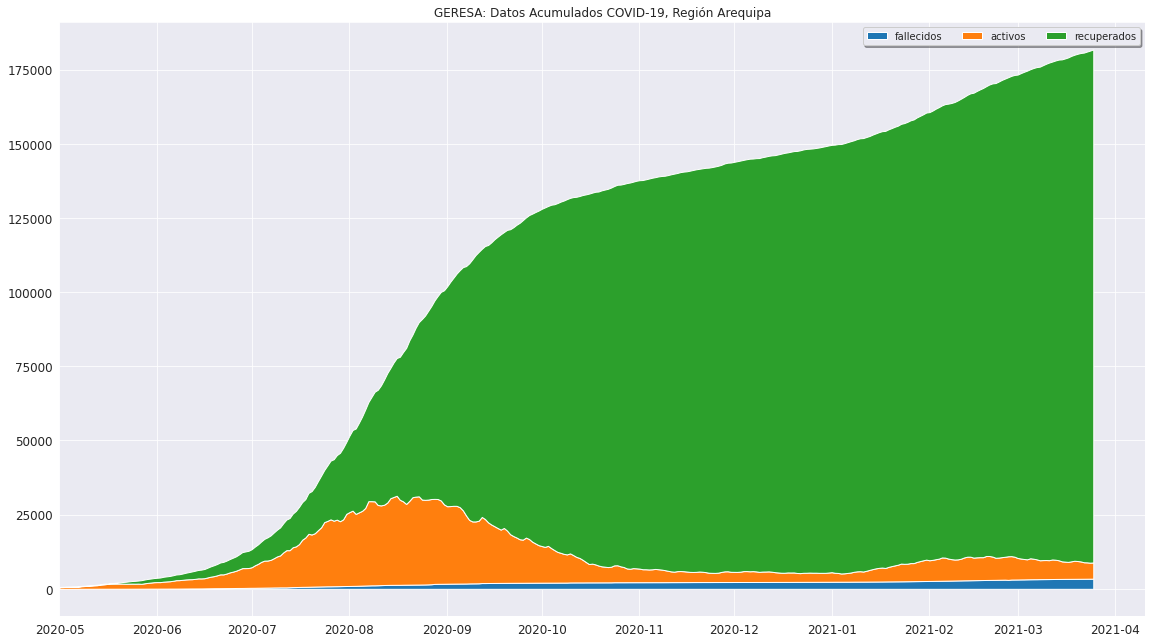

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16,9))

x1 = data_map_arequipa.index
x2 = data_map_arequipa['hito1']
x3 = data_map_arequipa['hito2']
x4 = data_map_arequipa['hito3']

ax1.fill_between(x1, 0, x2, label='fallecidos')
ax1.fill_between(x1, x2, x3, label='activos')
ax1.fill_between(x1, x3, x4, label='recuperados')

ax1.set(title='GERESA: Datos Acumulados COVID-19, Región Arequipa')

ax1.legend(fancybox=True, shadow=True, ncol=4)

fig.tight_layout()
ax1.tick_params(labelsize=12)
ax1.set_xlim([pd.to_datetime('2020-05-01'),None])
plt.savefig('image_13.png')
plt.show()
plt.clf()

#Plots - Confirmados diarios vs Recuperados diarios

In [ ]:
daily_confirmados_vs_recuperados = datos_arequipa.loc[:,['confirmados_diarios','recuperados_diarios']]
daily_confirmados_vs_recuperados['diario_c_vs_r'] = daily_confirmados_vs_recuperados.recuperados_diarios / \
                                                    daily_confirmados_vs_recuperados.confirmados_diarios

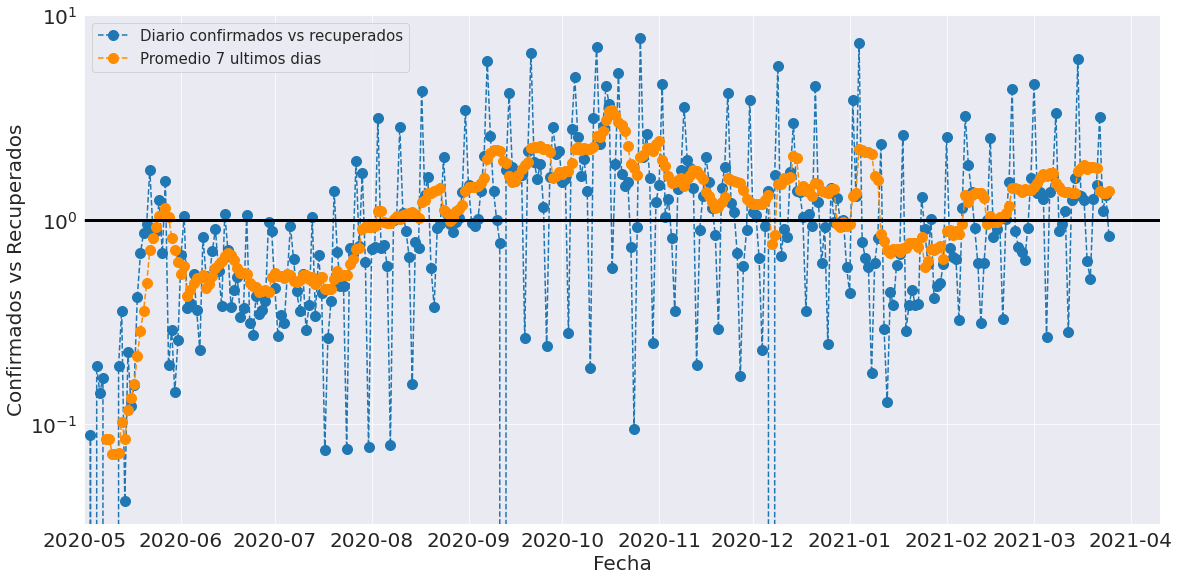

In [ ]:
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Confirmados vs Recuperados',fontsize=20)
ax1.set_xlabel('Fecha',fontsize=20)
#ax1.bar(daily_confirmados_vs_recuperados.index, daily_confirmados_vs_recuperados['diario_c_vs_r'],label='Diario confirmados vs recuperados')
ax1.plot(daily_confirmados_vs_recuperados['diario_c_vs_r'],'--o',ms=10,label='Diario confirmados vs recuperados')
ax1.plot(daily_confirmados_vs_recuperados['diario_c_vs_r'].rolling(7).mean(),'--o',ms=10,label='Promedio 7 ultimos dias', color='darkorange')
ax1.legend(fontsize=15)
ax1.set_yscale('log')

plt.axhline(1, color='k',lw=3)
fig.tight_layout()
ax1.tick_params(labelsize=20)
ax1.set_xlim([pd.to_datetime('2020-05-01'),None])
plt.savefig('image_14.png')
plt.show()

# SIR Function

DatetimeIndex(['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-09', '2020-05-10',
               ...
               '2021-03-16', '2021-03-17', '2021-03-18', '2021-03-19',
               '2021-03-20', '2021-03-21', '2021-03-22', '2021-03-23',
               '2021-03-24', '2021-03-25'],
              dtype='datetime64[ns]', name='date', length=329, freq=None)


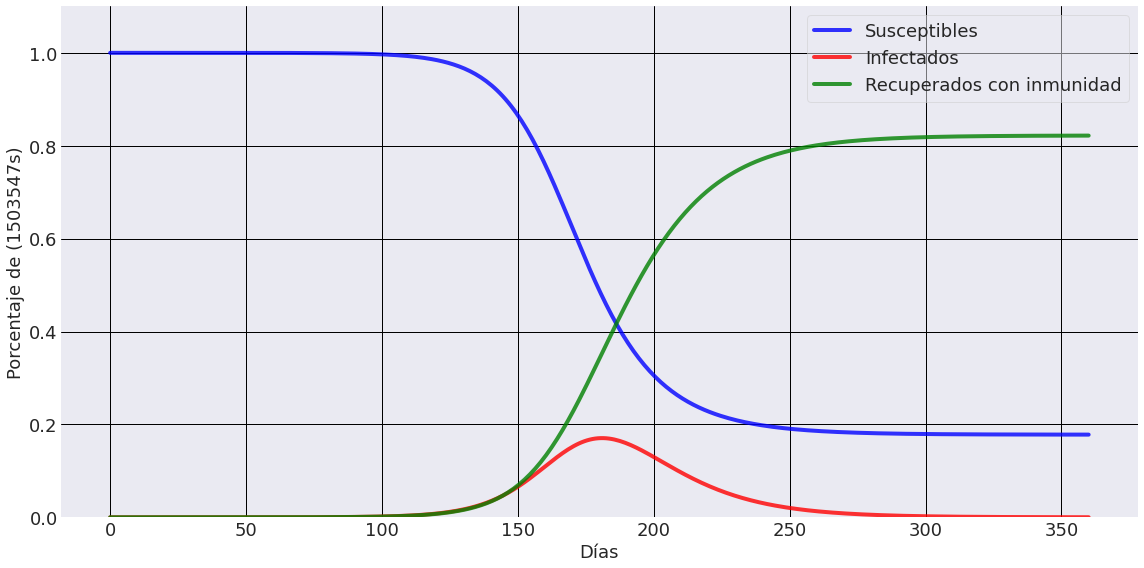

In [ ]:
from scipy.integrate import odeint

# Total population, Arequipa
N = 1503547
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.15, 1/14    #  https://www.worldometers.info/coronavirus/coronavirus-incubation-period/#24
# A grid of time points (in days)
t = np.linspace(0, 360, 360)
print(datos_arequipa.index)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w',figsize=(16,8))
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.8, lw=4, label='Susceptibles')
ax.plot(t, I/N, 'r', alpha=0.8, lw=4, label='Infectados')
ax.plot(t, R/N, 'g', alpha=0.8, lw=4, label='Recuperados con inmunidad')
ax.set_xlabel('Días',fontsize=18)
ax.set_ylabel('Porcentaje de ('+str(N)+'s)',fontsize=18)
ax.set_ylim(0,1.1)
ax.yaxis.set_tick_params(length=0,labelsize=18)
ax.xaxis.set_tick_params(length=0,labelsize=18)
ax.grid(b=True, which='both',axis='both', c='black', lw=1, ls='-')
legend = ax.legend(fontsize=18)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
fig.tight_layout()
plt.savefig('image_15.png')
plt.savefig('SIR_Model.pdf')

plt.show()

# OTROS (No Ejecutar)

In [ ]:
#datos_sinadef_arequipa_2020 = datos_sinadef_arequipa[datos_sinadef_arequipa['FECHA'] >= '2020-03-29']
datos_sinadef_arequipa_2020 = datos_sinadef_arequipa[datos_sinadef_arequipa['FECHA'] >= '2020-05-25']
#datos_sinadef_arequipa_2020 = datos_sinadef_arequipa[datos_sinadef_arequipa['EDAD'] != 'SIN REGISTRO']

from datetime import datetime
datetime_str = '2020-03-29 00:00:00'
datetime_object = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')

datos_sinadef_arequipa_2020['DIA'] = (pd.to_datetime(datos_sinadef_arequipa_2020['FECHA']) - datetime_object).dt.days

datos_sinadef_arequipa_2020['DIA'] = datos_sinadef_arequipa_2020['DIA'].astype('int')
datos_sinadef_arequipa_2020.sort_values('FECHA')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Nº,TIPO SEGURO,SEXO,EDAD,TIEMPO EDAD,ESTADO CIVIL,NIVEL DE INSTRUCCIÓN,COD# UBIGEO DOMICILIO,PAIS DOMICILIO,DEPARTAMENTO DOMICILIO,PROVINCIA DOMICILIO,DISTRITO DOMICILIO,FECHA,AÑO,MES,TIPO LUGAR,INSTITUCION,MUERTE VIOLENTA,NECROPSIA,DEBIDO A (CAUSA A),CAUSA A (CIE-X),DEBIDO A (CAUSA B),CAUSA B (CIE-X),DEBIDO A (CAUSA C),CAUSA C (CIE-X),DEBIDO A (CAUSA D),CAUSA D (CIE-X),DEBIDO A (CAUSA E),CAUSA E (CIE-X),DEBIDO A (CAUSA F),CAUSA F (CIE-X),SEMANA,AÑOSEMANA,MESDIA,AÑO2,DIASEMANA,DIA
2111,41043,IGNORADO,MASCULINO,52,AÑOS,CASADO,IGNORADO,92-33-04-05-03-000,PERU,AREQUIPA,CASTILLA,AYO,2020-05-25,2020,5,EESS,GOBIERNO REGIONAL,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,NEUMONIA POR SARS COV 2,U071,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,22,2020-22,05-25,2020,0,57
2278,46970,SIS,MASCULINO,68,AÑOS,CASADO,PRIMARIA COMPLETA,92-33-04-01-29-000,PERU,AREQUIPA,AREQUIPA,JOSE LUIS BUSTAMANTE Y RIVERO,2020-05-25,2020,5,EESS,GOBIERNO REGIONAL,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,ENFERMEDAD RESPIRATORIA AGUDA DEBIDO AL NUEVO ...,U071,SINDROME DE DIFICULTAD RESPIRATORIA DEL ADULTO,J80X,OBESIDAD NO ESPECIFICADA,E669,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,22,2020-22,05-25,2020,0,57
2279,46996,ESSALUD,MASCULINO,78,AÑOS,CASADO,SUPERIOR UNIV. COMP.,92-33-04-01-23-000,PERU,AREQUIPA,AREQUIPA,YANAHUARA,2020-05-25,2020,5,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,NEUMONIA,J189,SEPTICEMIA,A419,ALZHEIMER,F009,INSUFICIENCIA RESPIRATORIA,J969,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,22,2020-22,05-25,2020,0,57
2280,47191,IGNORADO,MASCULINO,72,AÑOS,SOLTERO,PRIMARIA COMPLETA,92-33-04-01-03-000,PERU,AREQUIPA,AREQUIPA,CERRO COLORADO,2020-05-25,2020,5,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,FALLA MULTIORGANICA,R688,CARCINOMA DE PROSTATA,D075,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,22,2020-22,05-25,2020,0,57
2281,47298,SIS,MASCULINO,74,AÑOS,CASADO,PRIMARIA COMPLETA,92-33-04-01-26-000,PERU,AREQUIPA,AREQUIPA,MARIANO MELGAR,2020-05-25,2020,5,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,FALLA MULTIORGANICA,SIN REGISTRO,DEFICIENCIA HEPATO RENAL,SIN REGISTRO,CÁNCER DE PROSTATA,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,22,2020-22,05-25,2020,0,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29082,592185,ESSALUD,MASCULINO,60,AÑOS,CASADO,SUPERIOR UNIV. COMP.,92-33-04-01-23-000,PERU,AREQUIPA,AREQUIPA,YANAHUARA,2021-03-24,2021,3,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,FALLA MULTISISTEMICA,SIN REGISTRO,INSUFICIENCIA HEPATO PANCREATICA,SIN REGISTRO,CANCER DE PANCREAS,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,12,2021-12,03-24,2021,2,360
29071,591826,SIS,MASCULINO,2,AÑOS,SOLTERO,NINGUN NIVEL / ILETRADO,92-33-04-01-20-000,PERU,AREQUIPA,AREQUIPA,TIABAYA,2021-03-24,2021,3,EESS,PRIVADO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,FALLA HEPATICA AGUDA,SIN REGISTRO,SHOCK SEPTICO,SIN REGISTRO,SEPSIS,SIN REGISTRO,MENINGITIS AGUDA,SIN REGISTRO,MALFORMACION DEL SNC PORTADOR DE VALVULA DE DE...,SIN REGISTRO,EPILEPSIA,SIN REGISTRO,12,2021-12,03-24,2021,2,360
29070,591819,ESSALUD,MASCULINO,65,AÑOS,CASADO,IGNORADO,92-33-04-01-02-000,PERU,AREQUIPA,AREQUIPA,CAYMA,2021-03-24,2021,3,EESS,ESSALUD,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA SARS,J129,INFECCION POR SARS COV 2,U071,SIN REGISTRO,SIN REGISTRO,HIPERTENSION ARTERIAL,I10X,SIN REGISTRO,SIN REGISTRO,12,2021-12,03-24,2021,2,360
29083,592243,ESSALUD,FEMENINO,66,AÑOS,SOLTERO,IGNORADO,92-33-04-01-02-000,PERU,AREQUIPA,AREQUIPA,CAYMA,2021-03-24,2021,3,EESS,ESSALUD,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA VIRAL,

189.2779080879159 91.26379308392217


NameError: ignored

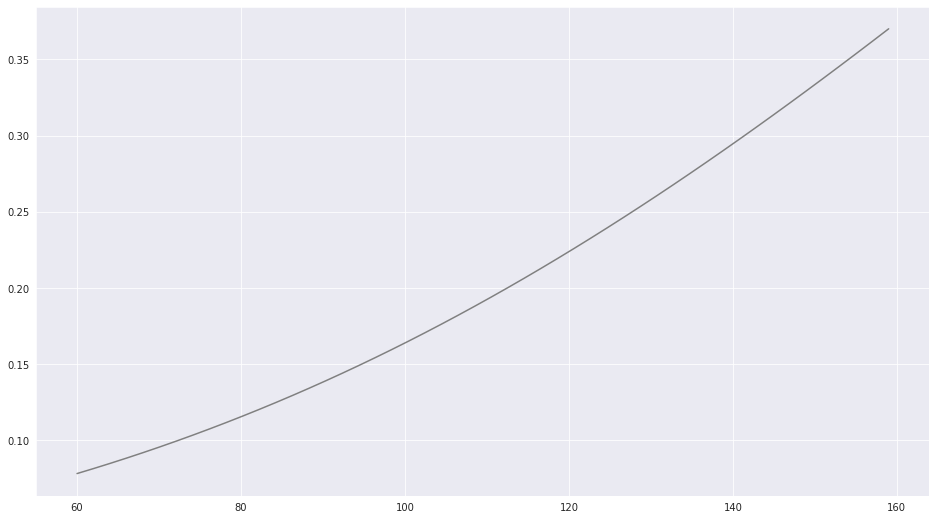

In [ ]:
mean = datos_sinadef_arequipa_2020['DIA'].mean()
std = datos_sinadef_arequipa_2020['DIA'].std()

print(mean, std)

# Make a norm object
from scipy.stats import norm
dist = norm(mean, std)

# Evaluate the model CDF
#xs = np.linspace(0, 143)
xs = np.linspace(60, 159)
ys = dist.cdf(xs)

plt.figure(figsize=(16,9))

# Plot the model CDF
plt.plot(xs, ys, color='gray', label='Distribución Normal')

# Create and plot the Cdf of log_income
Cdf.from_seq(datos_sinadef_arequipa_2020['DIA']).plot(label='Distribución por Día')

# Label the axes
plt.xlabel('DIA')
plt.ylabel('CDF')
plt.legend(fontsize=15)
fig.tight_layout()
plt.show()

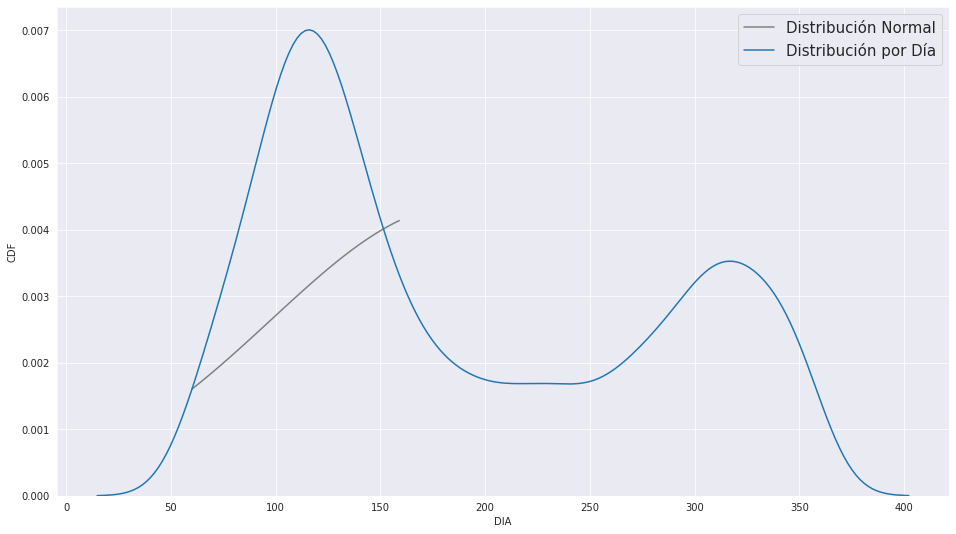

In [ ]:
# Evaluate the normal PDF
#xs = np.linspace(0, 143)
xs = np.linspace(60, 159)
ys = dist.pdf(xs)

plt.figure(figsize=(16,9))

# Plot the model PDF
plt.plot(xs, ys, color='gray', label='Distribución Normal')

# Plot the data KDE
sns.kdeplot(datos_sinadef_arequipa_2020['DIA'], label='Distribución por Día')
    
# Label the axes
plt.xlabel('DIA')
plt.ylabel('CDF')
plt.legend(fontsize=15)
fig.tight_layout()
plt.show()

# Comparacion SINADEF vs GERESA (No Ejecutar)

In [ ]:
#datos_sinadef_arequipa_dia = datos_sinadef_arequipa.groupby(['DIAANUAL', 'AÑO'])['Nº'].count()
datos_sinadef_arequipa_dia = datos_sinadef_raw[datos_sinadef_raw['FECHA'] <= dia_sinadef ]
datos_sinadef_arequipa_dia = datos_sinadef_arequipa_dia.groupby(['MESDIA', 'AÑO'])['Nº'].count()
datos_sinadef_arequipa_dia = datos_sinadef_arequipa_dia.to_frame().reset_index()
#datos_sinadef_arequipa_dia = datos_sinadef_arequipa_dia[datos_sinadef_arequipa_dia['DIAANUAL'] <= 222 ]
#datos_sinadef_arequipa_dia = datos_sinadef_arequipa_dia[datos_sinadef_arequipa_dia['MESDIA'] <= dia_sinadef ]
#datos_sinadef_arequipa_dia = datos_sinadef_arequipa_dia[datos_sinadef_arequipa_dia['MESDIA'] != '02-29' ]
datos_sinadef_arequipa_dia

,MESDIA,AÑO,Nº
0,01-01,2018,322
1,01-01,2019,345
2,01-01,2020,378
3,01-01,2021,514
4,01-02,2017,238
...,...,...,...
1538,12-30,2020,501
1539,12-31,2017,273
1540,12-31,2018,296
1541,12-31,2019,338


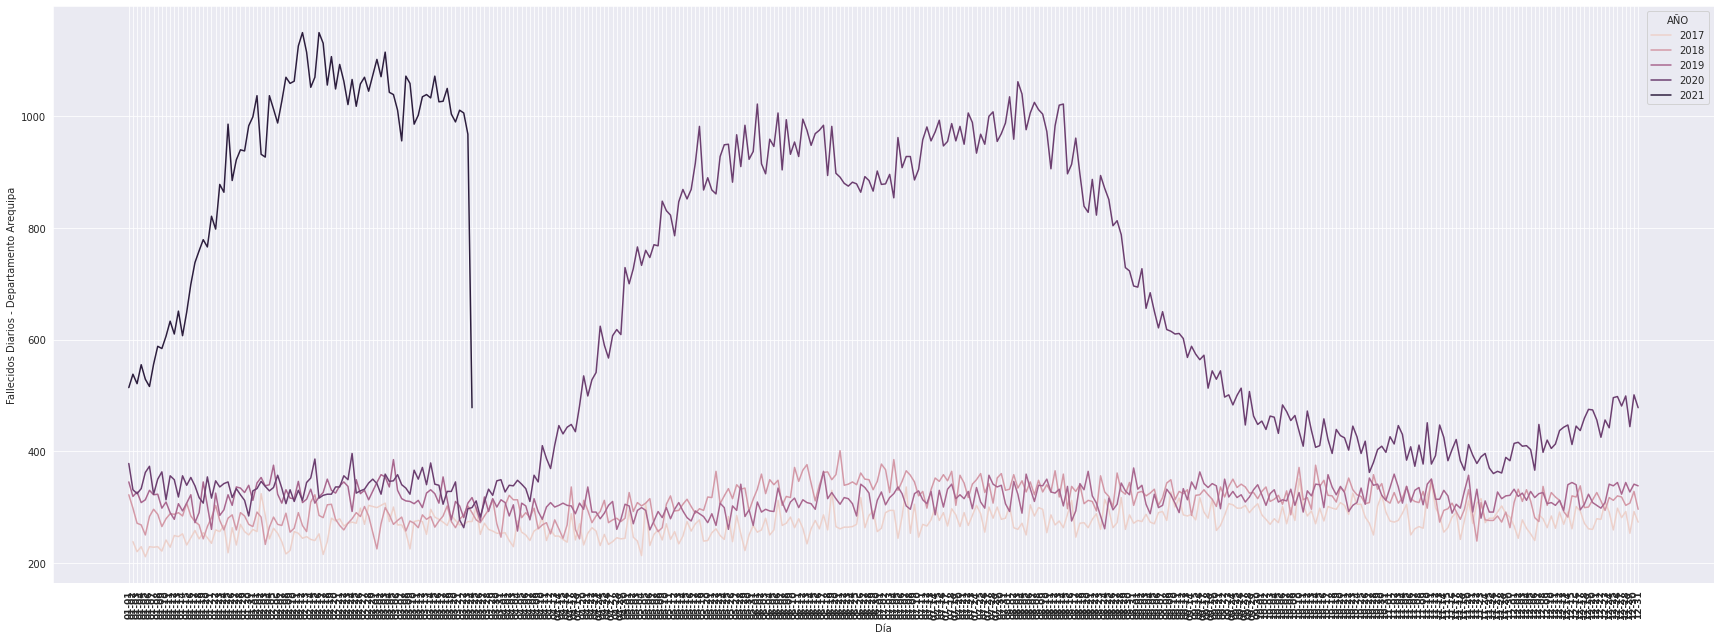

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))

sns.lineplot(data=datos_sinadef_arequipa_dia, x = 'MESDIA', y = 'Nº', hue='AÑO', ax=ax1)

plt.xlabel('Día')
plt.ylabel('Fallecidos Diarios - Departamento Arequipa')
plt.xticks(rotation=90, fontsize=9, fontweight='bold')
fig.tight_layout()
plt.savefig('image_25.png')
plt.savefig('SINADEF_DiariosTodasCausas.pdf')
plt.show()

In [ ]:
datos_arequipa.loc[datos_arequipa.index == '2020-12-28', 'week'] = '1'
datos_arequipa.loc[datos_arequipa.index == '2020-12-29', 'week'] = '1'
datos_arequipa.loc[datos_arequipa.index == '2020-12-30', 'week'] = '1'
datos_arequipa.loc[datos_arequipa.index == '2020-12-31', 'week'] = '1'
datos_arequipa.loc[datos_arequipa.index == '2020-12-28', 'year'] = '2021'
datos_arequipa.loc[datos_arequipa.index == '2020-12-29', 'year'] = '2021'
datos_arequipa.loc[datos_arequipa.index == '2020-12-30', 'year'] = '2021'
datos_arequipa.loc[datos_arequipa.index == '2020-12-31', 'year'] = '2021'

for index, row in datos_arequipa.iterrows():
    if index == pd.to_datetime('2021-01-01') or index == pd.to_datetime('2021-01-02') or index == pd.to_datetime('2021-01-03'):
        datos_arequipa.loc[index, 'week'] = 1
        datos_arequipa.loc[index, 'year'] = 2021
    if index >= pd.to_datetime('2021-01-04') and index <= pd.to_datetime('2021-01-10'):
        datos_arequipa.loc[index, 'week'] = 2
        datos_arequipa.loc[index, 'year'] = 2021
    if index >= pd.to_datetime('2021-01-11') and index <= pd.to_datetime('2021-01-24'):
        datos_arequipa.loc[index, 'week'] = 3
        datos_arequipa.loc[index, 'year'] = 2021
print(datos_arequipa[['week', 'year']])

datos_arequipa_semana = datos_arequipa.groupby(['week', 'year'])['fallecidos_diarios'].sum()
datos_arequipa_semana = datos_arequipa_semana.to_frame().reset_index()
#datos_arequipa_semana = datos_arequipa_semana[datos_arequipa_semana['week'] <= semana_sinadef ]

#datos_arequipa_semana

NameError: ignored

In [ ]:
datos_sinadef_arequipa_covid = datos_sinadef_arequipa[datos_sinadef_arequipa['CAUSA A (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA B (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA C (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA D (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA E (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA F (CIE-X)'].str.contains("U07") |
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA A)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA A)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA B)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA B)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA C)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA C)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA D)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA D)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA E)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA E)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA F)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA F)'].str.contains("CORONAVIRUS")
                                                       ]

#display(df_sinadef_raw_arequipa_covid)

datos_sinadef_arequipa_covid['week'] = pd.to_datetime(datos_sinadef_arequipa_covid['FECHA']).dt.week
datos_sinadef_arequipa_covid['year'] = pd.to_datetime(datos_sinadef_arequipa_covid['FECHA']).dt.year
datos_sinadef_arequipa_covid = datos_sinadef_arequipa_covid.reset_index(drop=True)

datos_sinadef_arequipa_semana_covid = datos_sinadef_arequipa_covid.groupby(['week', 'year'])['Nº'].count()
datos_sinadef_arequipa_semana_covid = datos_sinadef_arequipa_semana_covid.to_frame().reset_index()
#datos_sinadef_arequipa_semana_covid = datos_sinadef_arequipa_semana_covid[(datos_sinadef_arequipa_semana_covid['week'] >= 18) & (datos_sinadef_arequipa_semana_covid['week'] <= semana_sinadef)]

datos_sinadef_arequipa_semana_covid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,week,year,Nº
0,1,2021,53
1,2,2021,76
2,3,2021,93
3,4,2021,150
4,5,2021,163
5,6,2021,158
6,7,2021,140
7,8,2021,138
8,9,2021,121
9,10,2021,102


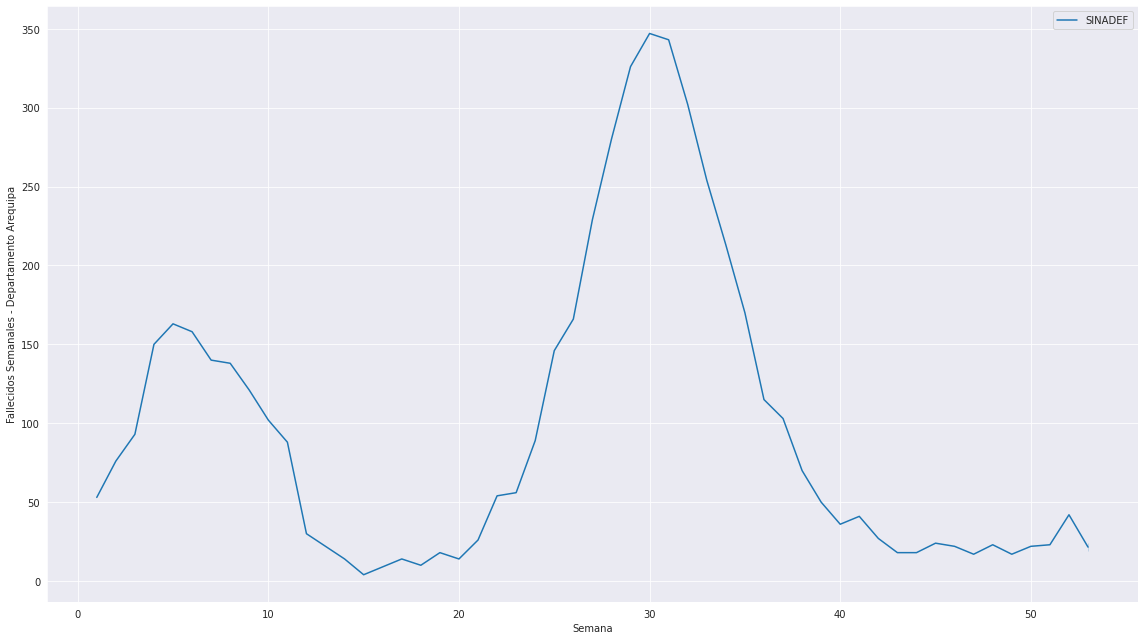

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.lineplot(data=datos_sinadef_arequipa_semana_covid, x = 'week', y = 'Nº', label='SINADEF', ax=ax1)
#sns.lineplot(data=datos_arequipa_semana, x = 'week', y = 'fallecidos_diarios', label='GERESA', ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Semanales - Departamento Arequipa')
fig.tight_layout()
plt.savefig('image_22.png')
plt.savefig('Fallecidos_COVID_SINADEF-GERESA.pdf')
plt.show()

In [ ]:
datos_arequipa_dia = datos_arequipa.groupby(['mesdia', 'year'])['fallecidos_diarios'].sum()
datos_arequipa_dia = datos_arequipa_dia.to_frame().reset_index()
datos_arequipa_dia = datos_arequipa_dia[datos_arequipa_dia['mesdia'] <= dia_sinadef ]
datos_arequipa_dia = datos_arequipa_dia[(datos_arequipa_dia['mesdia'] != '05-09')]
datos_arequipa_dia = datos_arequipa_dia[(datos_arequipa_dia['mesdia'] != '05-17')]
datos_arequipa_dia = datos_arequipa_dia.reset_index(drop=True)

datos_arequipa_dia.tail()

NameError: ignored

In [ ]:
datos_sinadef_arequipa_dia_covid = datos_sinadef_arequipa_covid.groupby(['MESDIA', 'AÑO'])['Nº'].count()
datos_sinadef_arequipa_dia_covid = datos_sinadef_arequipa_dia_covid.to_frame().reset_index()
datos_sinadef_arequipa_dia_covid = datos_sinadef_arequipa_dia_covid[(datos_sinadef_arequipa_dia_covid['MESDIA'] >= '05-01') & (datos_sinadef_arequipa_dia_covid['MESDIA'] <= dia_sinadef)]
datos_sinadef_arequipa_dia_covid = datos_sinadef_arequipa_dia_covid.reset_index(drop=True)

datos_sinadef_arequipa_dia_covid.tail()

,MESDIA,AÑO,Nº
233,12-27,2020,5
234,12-28,2020,4
235,12-29,2020,9
236,12-30,2020,7
237,12-31,2020,4


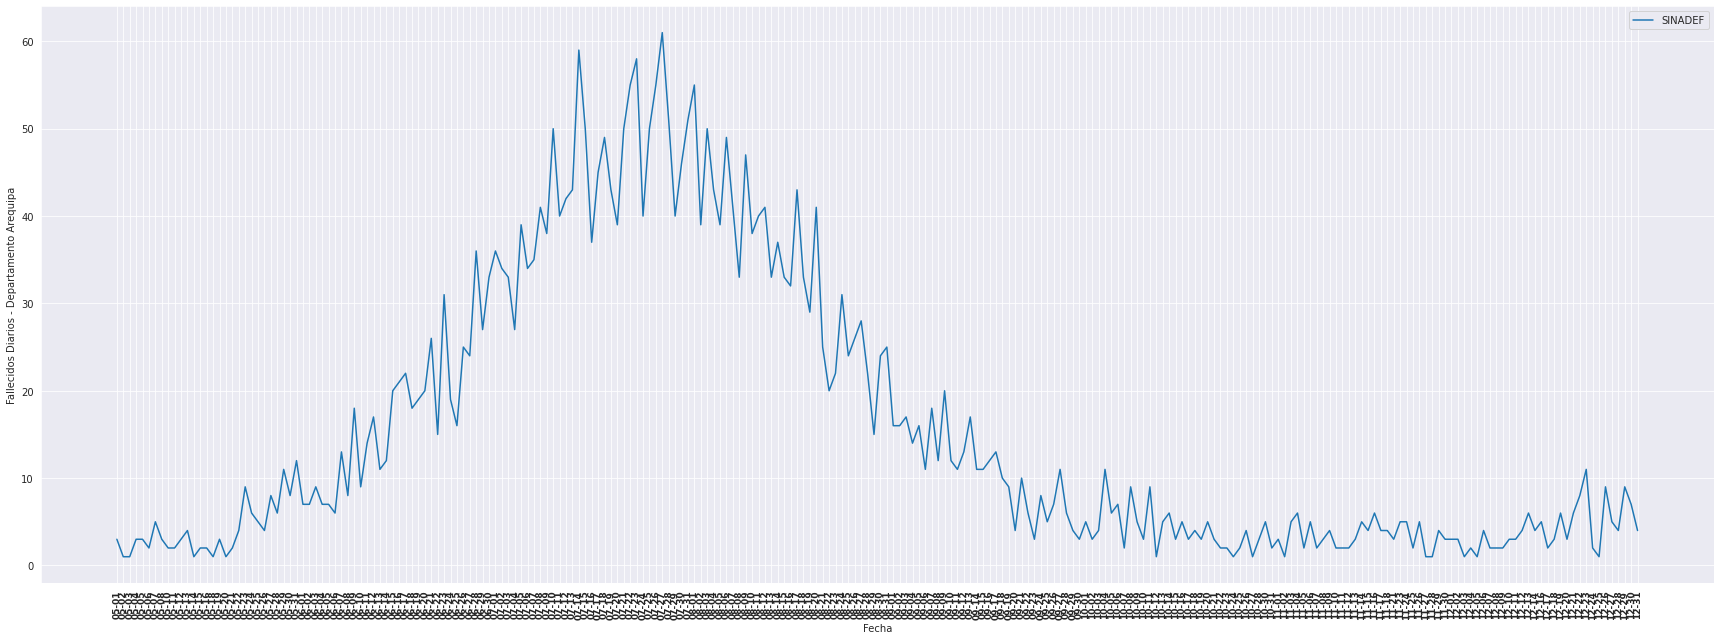

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
 
sns.lineplot(data=datos_sinadef_arequipa_dia_covid, x = 'MESDIA', y = 'Nº', label='SINADEF', ax=ax1)
#sns.lineplot(data=datos_arequipa_dia, x = 'mesdia', y = 'fallecidos_diarios', label='GERESA', ax=ax1)
 
plt.xlabel('Fecha')
plt.ylabel('Fallecidos Diarios - Departamento Arequipa')
plt.xticks(rotation=90, fontsize=9, fontweight='bold')
fig.tight_layout()
#plt.savefig('image_22.png')
plt.savefig('Fallecidos_COVID_SINADEF-GERESA_diario.pdf')
plt.show()

# Varios (No Ejecutar)

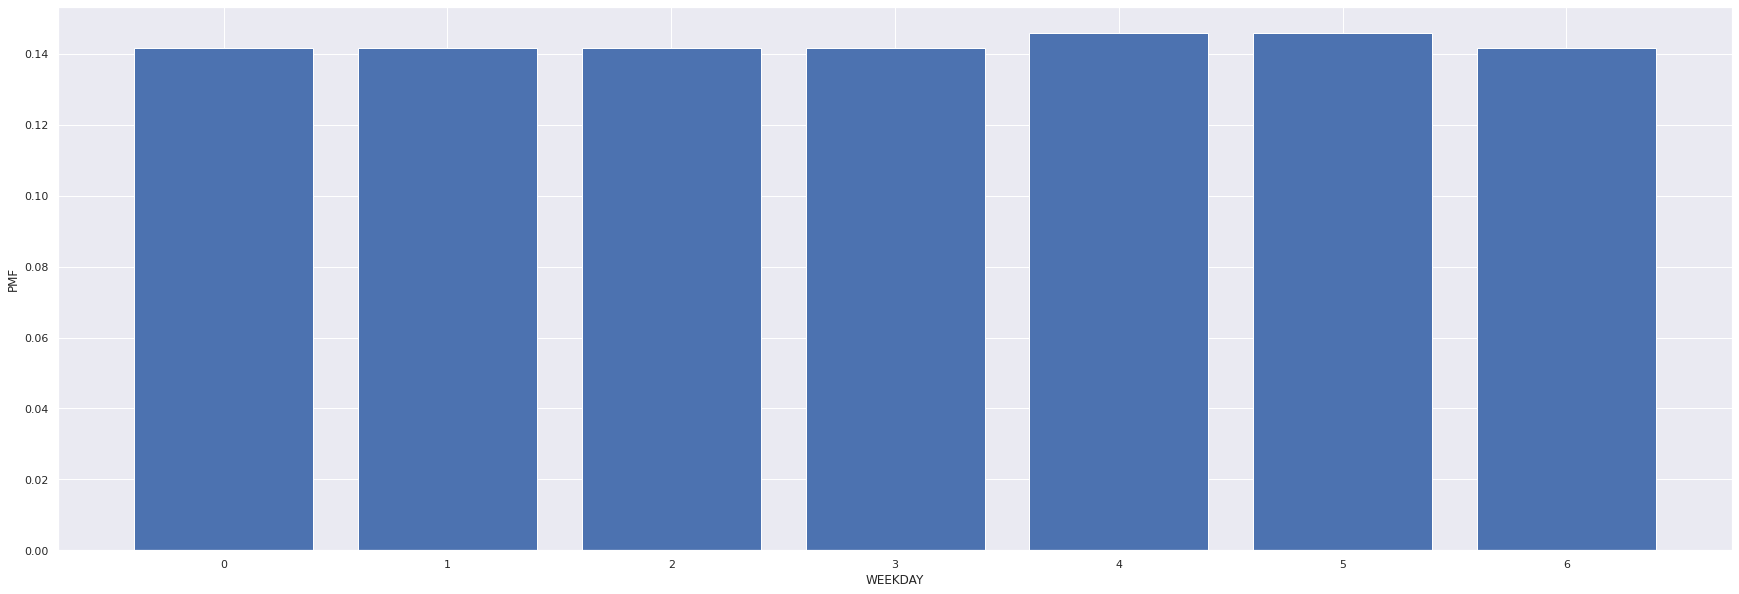

In [ ]:
metododx = datos_arequipa['weekday']
plt.figure(figsize=(30,10))
Pmf.from_seq(metododx).bar()

plt.xlabel('WEEKDAY')
plt.ylabel('PMF')
plt.show()

In [ ]:
datos_arequipa.tail()

,total_muestras,casos_positivos,casos_negativos,espera_resultado,defunciones,recuperados,hospitalizados_positivos,hospitalizados_sospechosos,uci_positivos,uci_sospechosos,trauma_shock,defunciones_minsa,defunciones_essalud,defunciones_clinicas,defunciones_domicilio,defunciones_sanidades,dia,weekday,week,year,muestras_diarias,confirmados_diarios,fallecidos_diarios,recuperados_diarios,hospitalizados_positivos_diarios,uci_positivos_diarios,positividad,mesdia,activos
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-08,1027730,145172,879789,2769,2308,139292,204,28,41,0,5,881,1223,39,123,42,221,1,50,2020,2150,127,3,211,-3,1,5,12-08,3572
2020-12-09,1029030,145207,881051,2772,2309,139489,216,28,43,0,6,881,1224,39,123,42,222,2,50,2020,1300,35,1,197,12,2,2,12-09,3409
2020-12-10,1033562,145505,885366,2691,2311,139687,212,29,43,0,6,882,1225,39,123,42,223,3,50,2020,4532,298,2,198,-4,0,6,12-10,3507
2020-12-11,1037631,145709,888851,3071,2314,139871,222,27,43,0,7,884,1226,39,123,42,224,4,50,2020,4069,204,3,184,10,0,5,12-11,3524
2020-12-12,1042534,145958,893012,3564,2316,140076,261,29,48,0,8,886,1226,39,123,42,225,5,50,2020,4903,249,2,205,39,5,5,12-12,3566


In [ ]:
datos_arequipa.describe()

,total_muestras,casos_positivos,casos_negativos,espera_resultado,defunciones,recuperados,hospitalizados_positivos,hospitalizados_sospechosos,uci_positivos,uci_sospechosos,trauma_shock,defunciones_minsa,defunciones_essalud,defunciones_clinicas,defunciones_domicilio,defunciones_sanidades,dia,weekday,week,year,muestras_diarias,confirmados_diarios,fallecidos_diarios,recuperados_diarios,hospitalizados_positivos_diarios,uci_positivos_diarios,positividad,activos
count,2.260000e+02,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.0,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000
mean,5.170149e+05,75930.460177,440575.659292,507.442478,1273.681416,63735.141593,300.269912,109.340708,43.792035,6.017699,2.920354,475.982301,693.690265,20.969027,60.252212,13.995575,112.500000,3.013274,34.212389,2020.0,4550.115044,642.933628,10.181416,619.438053,0.969027,0.119469,11.190265,10921.637168
std,3.467519e+05,56772.419406,290039.629772,804.127015,893.532249,55403.684685,155.007104,95.271606,13.089644,8.172020,4.053293,343.178139,483.535858,16.168389,52.482828,15.465373,65.384759,2.001067,9.346135,0.0,2299.268779,626.851136,13.847352,628.293306,44.586734,7.802499,6.667606,9483.874443
min,1.420800e+04,655.000000,13552.000000,0.000000,15.000000,83.000000,40.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,2020.0,0.000000,0.000000,0.000000,-224.000000,-251.000000,-46.000000,0.000000,557.000000
25%,1.634255e+05,11122.000000,152234.000000,25.250000,286.500000,4913.750000,198.500000,29.250000,35.000000,0.000000,0.000000,91.250000,128.250000,5.000000,3.000000,2.000000,56.250000,1.000000,26.000000,2020.0,3064.750000,192.750000,2.000000,140.500000,-8.750000,-2.000000,6.000000,3429.750000
50%,5.427760e+05,86853.000000,455874.500000,73.500000,1421.000000,55869.000000,269.000000,76.500000,46.000000,0.000000,0.000000,580.000000,772.000000,18.000000,41.000000,10.000000,112.500000,3.000000,34.000000,2020.0,4371.000000,365.500000,4.500000,296.000000,0.000000,0.000000,9.000000,6126.000000
75%,8.436378e+05,133465.750000,709374.250000,547.000000,2172.750000,125004.000000,427.500000,169.500000,52.000000,13.000000,5.000000,825.750000,1176.000000,38.000000,123.000000,10.000000,168.750000,5.000000,42.000000,2020.0,6301.750000,944.750000,14.000000,1056.500000,7.000000,2.000000,15.750000,18859.750000
max,1.042534e+06,145958.000000,893012.000000,3564.000000,2316.000000,140076.000000,668.000000,349.000000,74.000000,29.000000,16.000000,886.000000,1226.000000,39.000000,123.000000,42.000000,225.000000,6.000000,50.000000,2020.0,10143.000000,2530.000000,119.000000,2441.000000,267.000000,43.000000,31.000000,30029.000000


In [ ]:
datos_arequipa.corr()

,total_muestras,casos_positivos,casos_negativos,espera_resultado,defunciones,recuperados,hospitalizados_positivos,hospitalizados_sospechosos,uci_positivos,uci_sospechosos,trauma_shock,defunciones_minsa,defunciones_essalud,defunciones_clinicas,defunciones_domicilio,defunciones_sanidades,dia,weekday,week,year,muestras_diarias,confirmados_diarios,fallecidos_diarios,recuperados_diarios,hospitalizados_positivos_diarios,uci_positivos_diarios,positividad,activos
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,
total_muestras,1.000000,0.991587,0.999684,0.633858,0.991187,0.983844,0.203634,-0.260287,0.306145,-0.514421,0.593369,0.987867,0.981226,0.971906,0.954617,0.819469,0.992836,-0.000344,0.992267,NaN,0.081455,-0.047035,-0.115438,0.211594,-0.059558,-0.017842,-0.089478,0.094956
casos_positivos,0.991587,1.000000,0.988034,0.614408,0.997953,0.985396,0.219955,-0.279465,0.268478,-0.552163,0.643648,0.996366,0.991871,0.978317,0.952862,0.767898,0.969864,-0.000488,0.969313,NaN,0.074967,-0.036261,-0.113764,0.267140,-0.066802,-0.015833,-0.066500,0.135617
casos_negativos,0.999684,0.988034,1.000000,0.634764,0.988003,0.981528,0.200549,-0.255509,0.312716,-0.505765,0.581786,0.984350,0.977323,0.968704,0.952929,0.828115,0.995367,-0.000370,0.994798,NaN,0.083064,-0.048380,-0.115009,0.200904,-0.057987,-0.018232,-0.093139,0.087517
espera_resultado,0.633858,0.614408,0.634764,1.000000,0.597476,0.653460,-0.058372,-0.347096,0.264701,-0.417111,0.584864,0.596313,0.584603,0.631587,0.662023,0.462381,0.635329,0.011779,0.634598,NaN,-0.130410,-0.270349,-0.259148,-0.079204,-0.054326,-0.005491,-0.291629,-0.195753
defunciones,0.991187,0.997953,0.988003,0.597476,1.000000,0.976131,0.267923,-0.230352,0.297243,-0.519051,0.640768,0.995672,0.995156,0.977292,0.949763,0.759581,0.970620,-0.002444,0.970129,NaN,0.115767,0.007526,-0.077459,0.296315,-0.067969,-0.017744,-0.020348,0.177292
recuperados,0.983844,0.985396,0.981528,0.653460,0.976131,1.000000,0.075001,-0.397048,0.262557,-0.609043,0.620311,0.976759,0.963881,0.977308,0.968110,0.808795,0.968073,-0.003398,0.967612,NaN,-0.050730,-0.184844,-0.207861,0.124605,-0.063805,-0.012116,-0.220551,-0.035070
hospitalizados_positivos,0.203634,0.219955,0.200549,-0.058372,0.267923,0.075001,1.000000,0.573478,0.418316,0.224678,0.260728,0.235565,0.278008,0.196810,0.103803,-0.111643,0.189452,0.006723,0.189136,NaN,0.731817,0.742837,0.533326,0.719146,0.122938,0.037860,0.767101,0.853307
hospitalizados_sospechosos,-0.260287,-0.279465,-0.255509,-0.347096,-0.230352,-0.397048,0.573478,1.000000,0.220214,0.797109,-0.270649,-0.233658,-0.184031,-0.288169,-0.318537,-0.333173,-0.238391,-0.017811,-0.237707,NaN,0.616260,0.726517,0.467154,0.452341,-0.147994,-0.094312,0.761199,0.668272
uci_positivos,0.306145,0.268478,0.312716,0.264701,0.297243,0.262557,0.418316,0.220214,1.000000,0.089032,0.235244,0.260613,0.277584,0.350441,0.362842,0.142548,0.337788,-0.050458,0.339134,NaN,0.214692,0.060292,0.123643,0.029849,0.094388,0.287193,0.069813,0.045335


In [ ]:
datos_arequipa['WEEKDAY'] = datos_arequipa.index.weekday

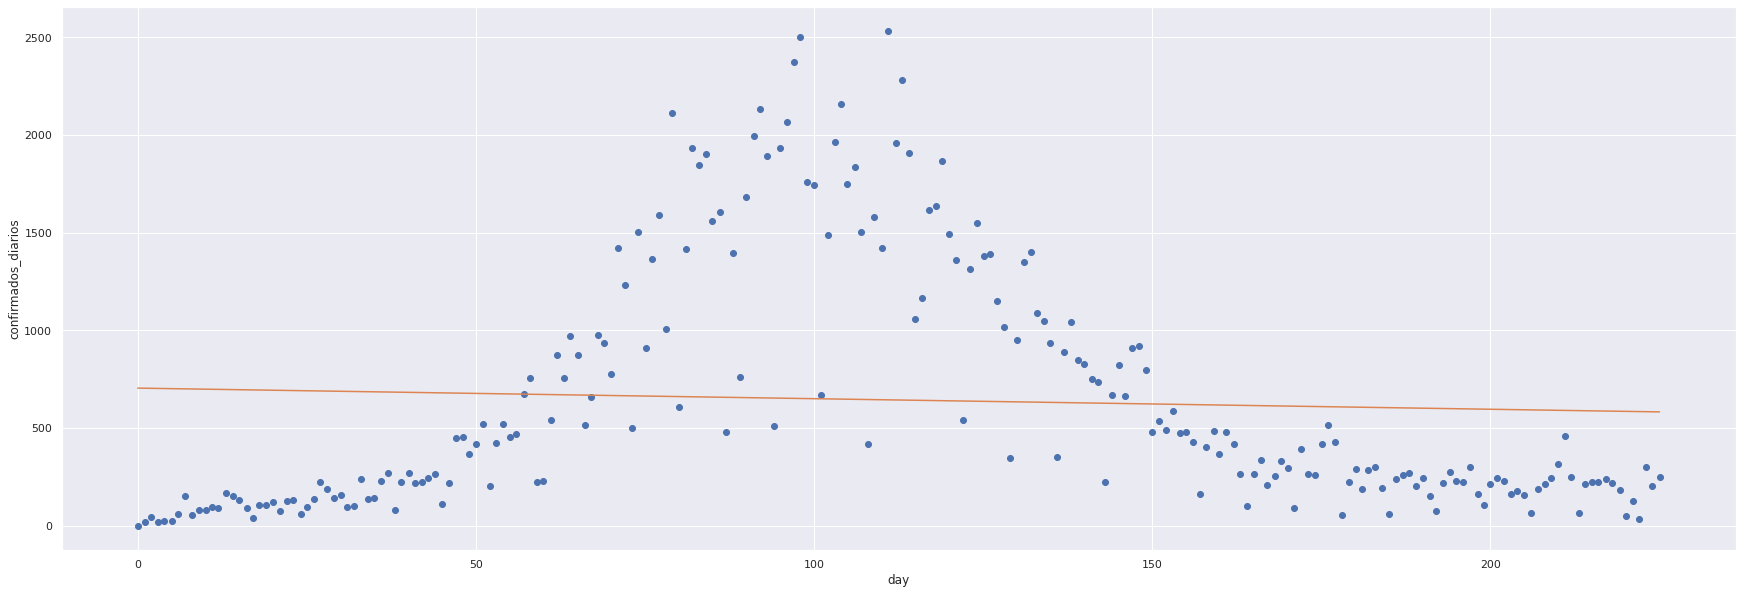

In [ ]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['confirmados_diarios']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('day')
plt.ylabel('confirmados_diarios')
plt.show()

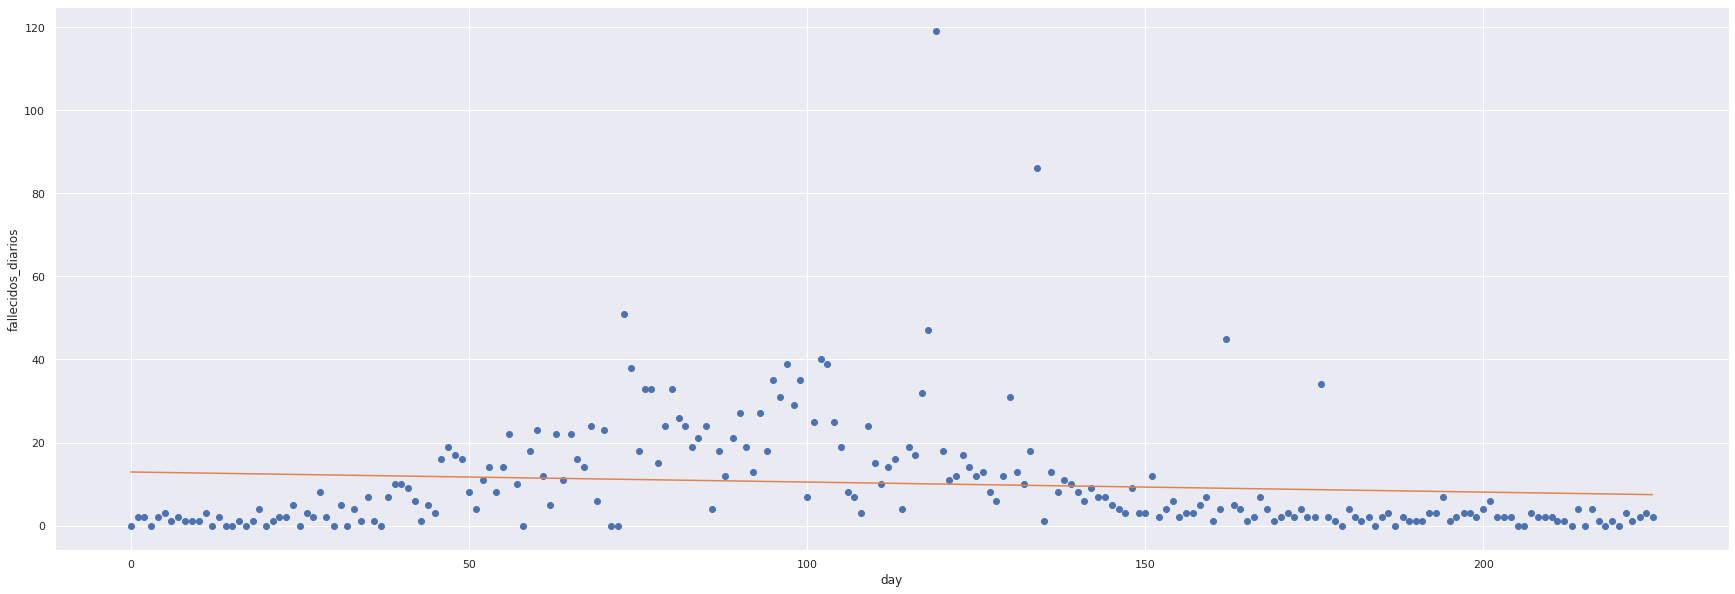

In [ ]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['fallecidos_diarios']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('day')
plt.ylabel('fallecidos_diarios')
plt.show()

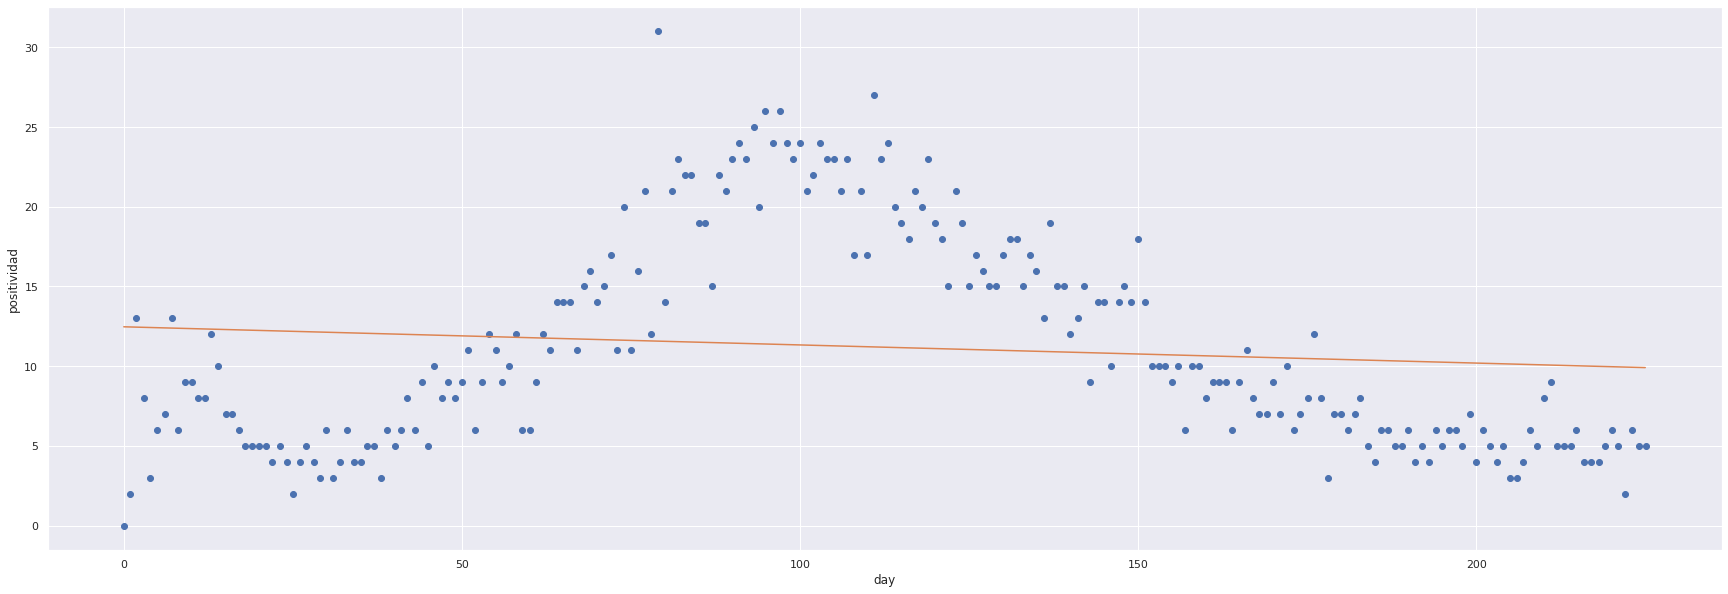

In [ ]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['positividad']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('day')
plt.ylabel('positividad')
plt.show()

In [ ]:
import statsmodels.formula.api as smf

results = smf.ols('positividad ~ dia', data=datos_arequipa).fit()
results.params

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Intercept    12.470625
dia          -0.011381
dtype: float64

Cada dia la linea de regresion aumenta un 0.01

In [ ]:
datos_arequipa['dia2'] = datos_arequipa['dia'] ** 2
datos_arequipa['dia3'] = datos_arequipa['dia'] ** 3

model = smf.ols('positividad ~ dia + dia2 + dia3', data=datos_arequipa)

results = model.fit()
results.params

Intercept   -0.386590
dia          0.382045
dia2        -0.002400
dia3         0.000003
dtype: float64

In [ ]:
df = pd.DataFrame()
df['dia'] = np.linspace(0, 90)
df['dia2'] = df['dia'] ** 2
df['dia3'] = df['dia'] ** 3

pred12 = results.predict(df)

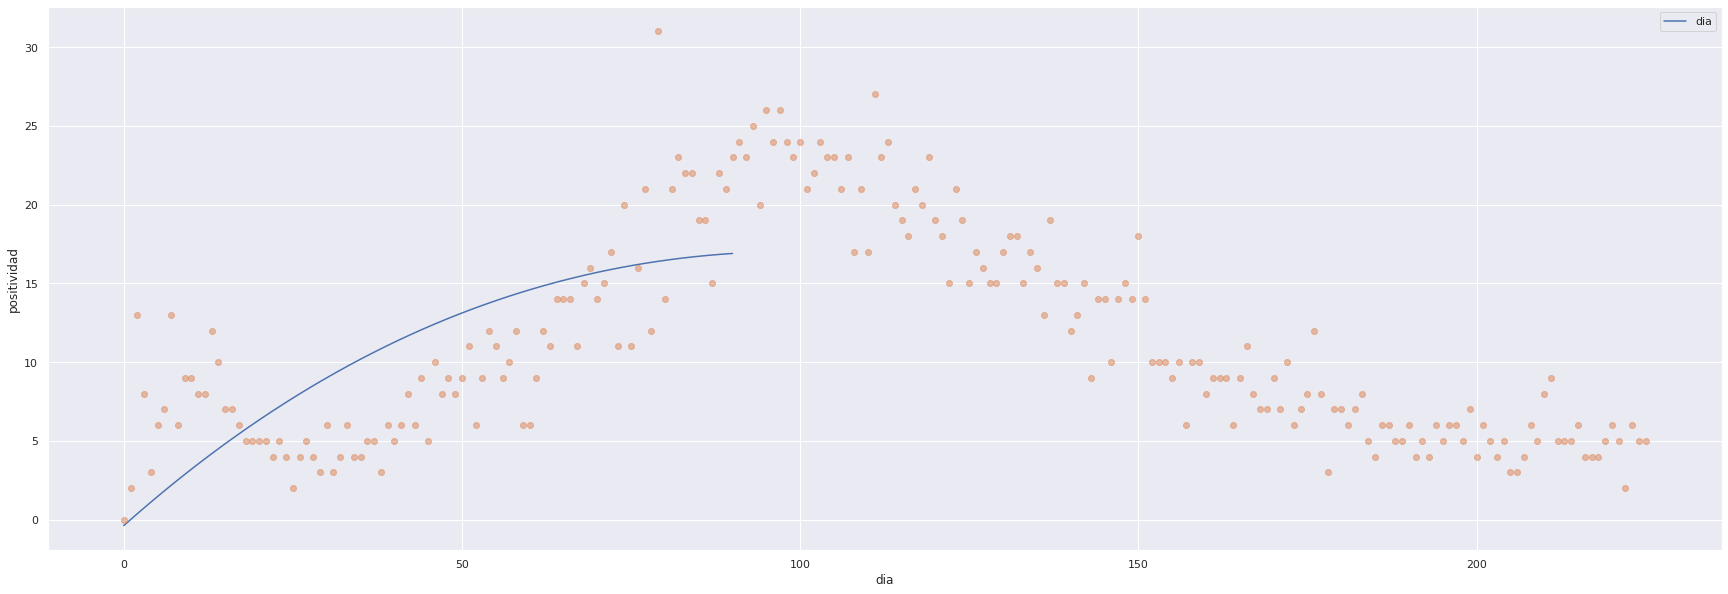

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(df['dia'], pred12, label='dia')
plt.plot(datos_arequipa['dia'], datos_arequipa['positividad'], 'o', alpha=0.5)

plt.xlabel('dia')
plt.ylabel('positividad')
plt.legend()
plt.show()

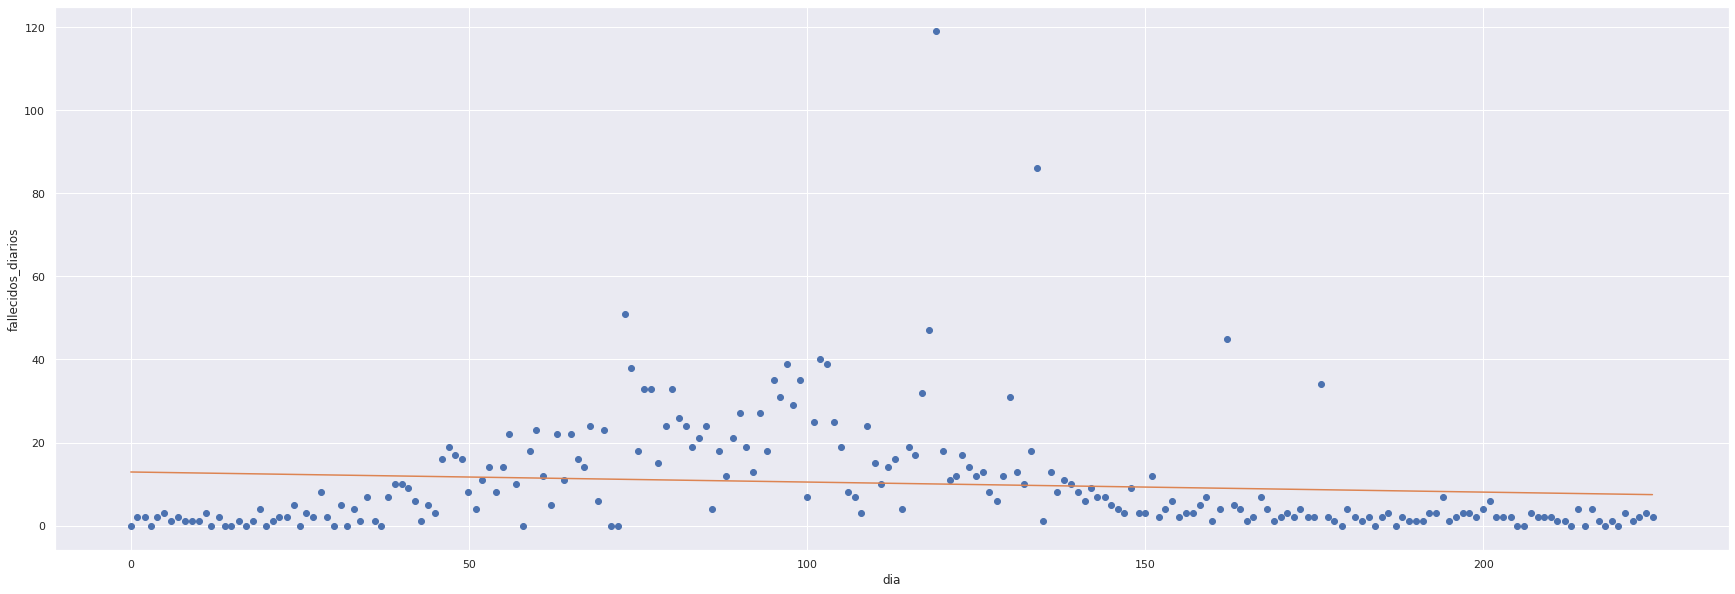

In [ ]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['fallecidos_diarios']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('dia')
plt.ylabel('fallecidos_diarios')
plt.show()

In [ ]:
results = smf.ols('fallecidos_diarios ~ dia + positividad', data=datos_arequipa).fit()
results.params

Intercept     -1.946326
dia           -0.010666
positividad    1.191007
dtype: float64

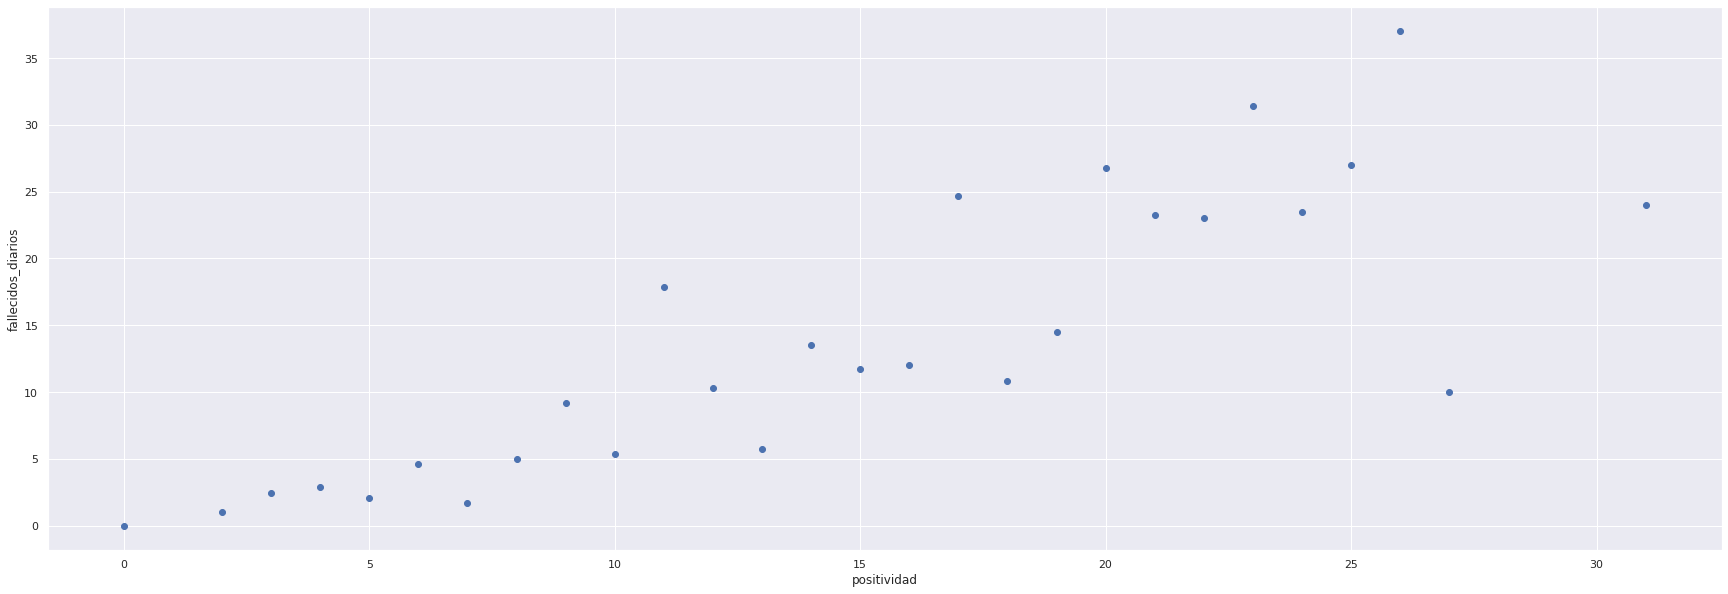

In [ ]:
#grouped = datos_arequipa.groupby('dia')
grouped = datos_arequipa.groupby('positividad')
mean_positividad_by_weekday = grouped['fallecidos_diarios'].mean()
plt.figure(figsize=(30,10))
plt.plot(mean_positividad_by_weekday, 'o')

plt.xlabel('positividad')
plt.ylabel('fallecidos_diarios')
plt.show()

In [ ]:
datos_arequipa['positividad2'] = datos_arequipa['positividad'] ** 2
datos_arequipa['dia2'] = datos_arequipa['dia'] ** 2

model = smf.ols('fallecidos_diarios ~ dia + dia2 + positividad + positividad2', data=datos_arequipa)
results = model.fit()
results.params

Intercept      -0.705059
dia             0.157081
dia2           -0.000762
positividad     0.144623
positividad2    0.026475
dtype: float64

In [ ]:
df = pd.DataFrame()
df['positividad'] = np.linspace(0, 13)
df['positividad2'] = df['positividad'] ** 2

df['dia'] = np.linspace(0, 90)
df['dia2'] = df['dia'] ** 2

pred12 = results.predict(df)

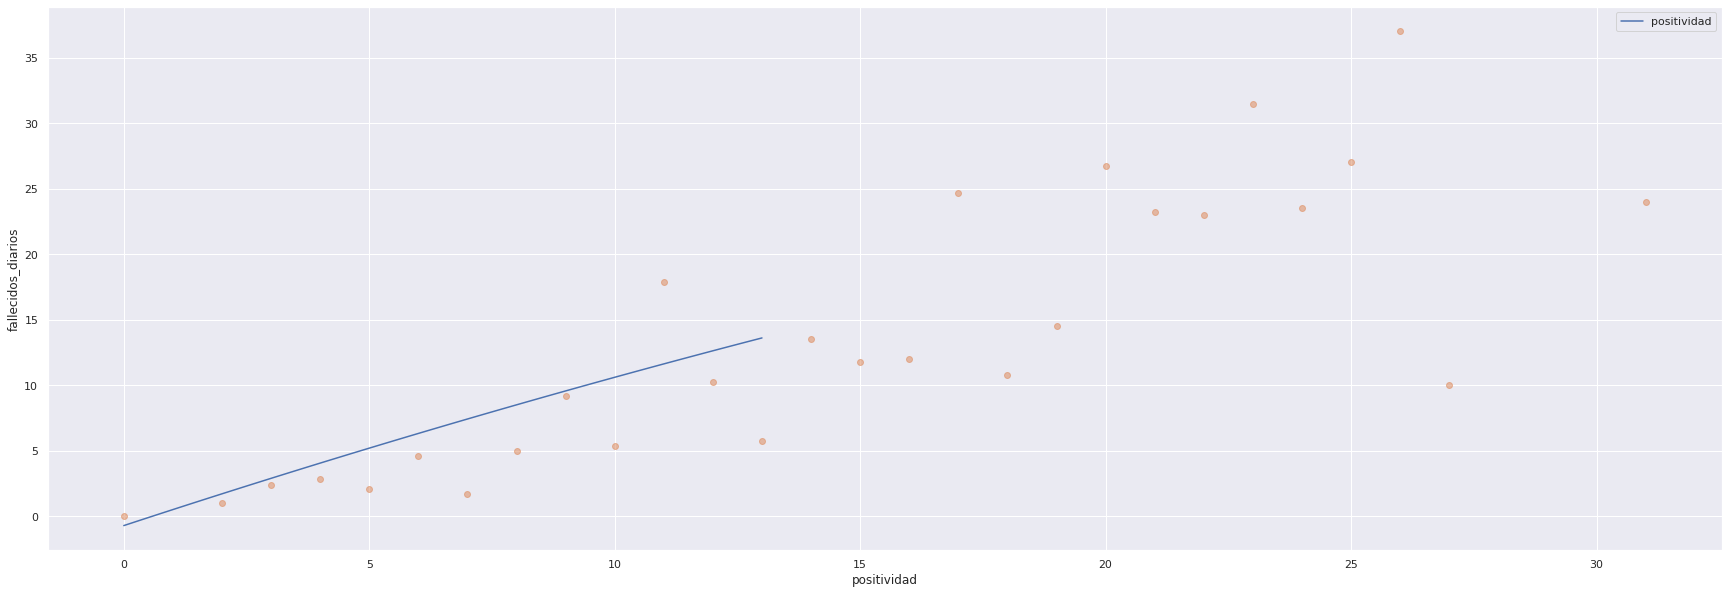

In [ ]:
#plt.plot(df['dia'], pred12, label='dia')
plt.figure(figsize=(30,10))
plt.plot(df['positividad'], pred12, label='positividad')
plt.plot(mean_positividad_by_weekday, 'o', alpha=0.5)

#plt.xlabel('dia')
plt.xlabel('positividad')
plt.ylabel('fallecidos_diarios')
plt.legend()
plt.show()

# Guardar

In [ ]:
from google.colab import files
for i in range(1,26):
    files.download('image_' + str(i) + '.png')